In [1]:
# Install the OpenAI and LangChain libraries
# - `openai`: Provides access to OpenAI's GPT models for tasks like text generation, embeddings, and completions.
# - `langchain`: A framework for building applications using large language models (LLMs).
#                Includes tools for chaining prompts, memory, and integrations like knowledge graphs.

!pip install -q openai langchain


# Attempt to install the LangChain Community library
# - `langchain-community`: This may refer to a community-supported version or extensions of LangChain.
#   Ensure this package exists and is maintained if errors occur during installation.

!pip install -q langchain-community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.2 MB/s eta 0:00:00


In [2]:
!pip install rdflib  SPARQLWrapper  matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.1/565.1 kB 11.2 MB/s eta 0:00:00


This script initializes the OpenAI API client and defines a function to interact with the GPT model. The get_chat_response function sends a user-provided text input to the GPT model (gpt-3.5-turbo) and returns the model's response.

In [3]:
import os
from openai import OpenAI

# Set the API key in the environment variable
os.environ["OPENAI_API_KEY"] = "sk-MNL1gYbV6CyXkh2rwPxao_D7n8nSxwW4_0wozr5sUtT3BlbkFJoEpwVXUH_Z3deg71NI-mM8QqSOkOGzQ5WDXmQ8FQEA" # Replace with your actual API key

client = OpenAI()

def get_chat_response(text):
    """
    This function takes a text input and returns the chat completion message.
    """
    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": text,
            }
        ],
        model="gpt-3.5-turbo",
    )
    return chat_completion.choices[0].message.content


In [ ]:
import os
import re
import json
import random
import logging
import textwrap
import unicodedata
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import spacy

from collections import defaultdict, Counter
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics.pairwise import cosine_distances, cosine_similarity
from sklearn.linear_model import LinearRegression
from scipy.stats import wasserstein_distance

from langchain.chat_models import ChatOpenAI
from langchain.graphs.networkx_graph import NetworkxEntityGraph, KnowledgeTriple
from langchain.graphs.graph_document import Node, Relationship, GraphDocument
from langchain.chains import GraphQAChain
from langchain_core.documents import Document

from sentence_transformers import SentenceTransformer
from openai import OpenAI
from google.colab import drive


In [10]:
drive.mount('/content/drive')
# Path to your PrimeKG dataset
file_path = "/content/drive/MyDrive/PrimeKG_Data/final_test.json"

def load_primekg_data(file_path):
    """
    Load PrimeKG data from a JSON file.

    Parameters:
    - file_path: Path to the JSON file containing PrimeKG data

    Returns:
    - List of data entries from the JSON file
    """
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        print(f"Successfully loaded {len(data)} entries from {file_path}")
        return data
    except Exception as e:
        print(f"Error loading data: {e}")
        return []

def is_diabetes_related(text):
    """
    Check if text contains diabetes-related terms.

    Parameters:
    - text: Text to check

    Returns:
    - Boolean indicating if the text is diabetes-related
    """
    # Core diabetes terms are weighted more heavily
    core_diabetes_terms = [
        'diabetes', 'diabetic', 'insulin', 'glucose',
        'type 1 diabetes', 'type 2 diabetes', 't1d', 't2d'
    ]

    # Secondary related terms
    secondary_terms = [
        'hyperglycemia', 'hypoglycemia', 'glycemic', 'a1c',
        'hemoglobin a1c', 'gestational diabetes', 'prediabetes',
        'metabolic syndrome', 'pancreatic', 'islet', 'beta cell',
        'metformin', 'glucagon', 'diabetic retinopathy',
        'diabetic nephropathy', 'diabetic neuropathy'
    ]

    text_lower = text.lower()

    # Check core terms first (stronger relation)
    for term in core_diabetes_terms:
        if term in text_lower:
            return 2  # Higher relevance score

    # Check secondary terms
    for term in secondary_terms:
        if term in text_lower:
            return 1  # Lower relevance score

    return 0  # Not related

def extract_diabetes_knowledge_graph(data, max_parts=10):
    """
    Extract strongly connected diabetes-related knowledge graph triples from PrimeKG data.

    Parameters:
    - data: List of entries from the PrimeKG JSON file
    - max_parts: Maximum number of parts to include

    Returns:
    - kg: List of diabetes-related knowledge graph triples
    - portion_indices: Dictionary mapping portion names to ranges of triple indices
    """
    # First pass: collect all diabetes-related triples
    all_diabetes_triples = []

    for entry in data:
        triples = entry.get('value', [])

        if not triples:
            continue

        for triple in triples:
            if len(triple) == 3:
                subject, predicate, obj = triple
                # Calculate relevance score for the triple
                subject_score = is_diabetes_related(subject)
                predicate_score = is_diabetes_related(predicate)
                object_score = is_diabetes_related(obj)
                total_score = subject_score + predicate_score + object_score

                if total_score > 0:
                    all_diabetes_triples.append((triple, total_score))

    # Sort triples by relevance score (descending)
    all_diabetes_triples.sort(key=lambda x: x[1], reverse=True)

    # Build a graph to find strongly connected components
    G = nx.Graph()
    for (triple, _) in all_diabetes_triples:
        subject, predicate, obj = triple
        G.add_edge(subject, obj, relation=predicate)

    # Find connected components
    connected_components = list(nx.connected_components(G))

    # Sort components by size (descending)
    connected_components.sort(key=len, reverse=True)

    # Take only the largest components up to max_parts
    components_to_use = connected_components[:max_parts]

    # Build a set of nodes that are in the components we want to keep
    nodes_to_keep = set()
    for component in components_to_use:
        nodes_to_keep.update(component)

    # Filter triples to only include those in the selected components
    filtered_triples = []
    for (triple, score) in all_diabetes_triples:
        subject, predicate, obj = triple
        if subject in nodes_to_keep and obj in nodes_to_keep:
            filtered_triples.append(triple)

    # Organize into parts
    kg = []
    portion_indices = {}

    # Group by connected components
    component_to_triples = defaultdict(list)
    for triple in filtered_triples:
        subject, _, obj = triple
        for i, component in enumerate(components_to_use):
            if subject in component and obj in component:
                component_to_triples[i].append(triple)
                break

    # Create portions based on components
    triple_index = 0
    portion_counter = 1

    print("\nStructured Diabetes Knowledge Graph (Focused on Strong Connections):\n")

    for component_idx, triples in component_to_triples.items():
        if not triples or portion_counter > max_parts:
            continue

        # Limit each part to a reasonable number of triples
        triples = triples[:20]  # Limit to 20 triples per component

        start_index = triple_index
        end_index = start_index + len(triples)
        portion_indices[f"Part {portion_counter}"] = range(start_index, end_index)

        print(f"\n# Part {portion_counter}")

        for triple in triples:
            subject, predicate, obj = triple

            print(f"({subject}) → ({predicate}) → ({obj})")

            kg.append((subject, predicate, obj))
            triple_index += 1

        print("-" * 80)
        portion_counter += 1

        # Stop if we've reached the maximum number of parts
        if portion_counter > max_parts:
            break

    return kg, portion_indices

def save_knowledge_graph(kg, output_file="focused_diabetes_kg.txt"):
    """
    Save the knowledge graph to a text file.

    Parameters:
    - kg: List of knowledge graph triples
    - output_file: Name of the output file
    """
    with open(output_file, "w", encoding="utf-8") as f:
        for triple in kg:
            f.write(f"( {triple[0]} , {triple[1]} , {triple[2]} )\n\n")

    print(f"\nFocused Diabetes Knowledge Graph saved as '{output_file}'.")

def perturb_kg_by_removing_parts(kg, parts_to_remove, portion_indices):
    """
    Perturbs the knowledge graph by removing triples from the specified parts.

    Parameters:
    - kg: The full knowledge graph triples list
    - parts_to_remove: List of part names to remove
    - portion_indices: Dictionary mapping part names to ranges of triple indices

    Returns:
    - perturbed_kg: The perturbed KG without the specified parts
    """
    indices_to_remove = set()
    for part in parts_to_remove:
        if part in portion_indices:
            indices_to_remove.update(portion_indices[part])

    perturbed_kg = [triple for i, triple in enumerate(kg) if i not in indices_to_remove]
    return perturbed_kg

def main():
    # Load data from PrimeKG JSON file
    primekg_data = load_primekg_data(file_path)

    if not primekg_data:
        print("No data loaded. Please check the file path.")
        return

    # Extract strongly connected diabetes-related knowledge graph and portion indices
    # Limit to approximately 10 parts
    kg, portion_indices = extract_diabetes_knowledge_graph(primekg_data, max_parts=10)

    if not kg:
        print("No diabetes-related information found in the dataset.")
        return

    print(f"\nFound {len(kg)} strongly connected diabetes-related triples in the dataset.")
    print(f"Organized into {len(portion_indices)} parts.")

    # Print portion indices
    print("\nPortion Indices:\n")
    for part, index_range in portion_indices.items():
        print(f"{part}: {index_range}")

    # Save knowledge graph to a text file
    save_knowledge_graph(kg)

    # Print the final KG in a readable format
    print("\nFinal Focused Diabetes Knowledge Graph List:\n")
    for triple in kg:
        print("(", triple[0], ",", triple[1], ", ", triple[2], ")")

if __name__ == "__main__":
    main()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Successfully loaded 17074 entries from /content/drive/MyDrive/PrimeKG_Data/final_test.json

Structured Diabetes Knowledge Graph (Focused on Strong Connections):


# Part 1
(Neonatal insulin-dependent diabetes mellitus) → (associated%20with) → (insulin-like growth factor receptor binding)
(insulin-like growth factor receptor binding) → (ppi) → (Neonatal insulin-dependent diabetes mellitus)
(Neonatal insulin-dependent diabetes mellitus) → (associated%20with) → (insulin-like growth factor receptor binding)
(insulin-like growth factor receptor binding) → (ppi) → (Neonatal insulin-dependent diabetes mellitus)
(Neonatal insulin-dependent diabetes mellitus) → (ppi) → (insulin-like growth factor receptor binding)
(insulin-like growth factor receptor binding) → (associated%20with) → (Neonatal insulin-dependent diabetes mellitus)
(Neonatal insulin-dependent diabetes me

In [24]:
# Initialize OpenAI client
client = OpenAI()  # Ensure OPENAI_API_KEY is set in your environment

# Path to your PrimeKG dataset
file_path = "/content/drive/MyDrive/PrimeKG_Data/final_test.json"

# Embedding cache and model
embedding_cache = {}
EMBEDDING_MODEL = "text-embedding-3-small"

def load_primekg_data(file_path):
    """
    Load PrimeKG data from a JSON file.

    Parameters:
    - file_path: Path to the JSON file containing PrimeKG data

    Returns:
    - List of data entries from the JSON file
    """
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        print(f"Successfully loaded {len(data)} entries from {file_path}")
        return data
    except Exception as e:
        print(f"Error loading data: {e}")
        return []

def is_diabetes_related(text):
    """
    Check if text contains diabetes-related terms.

    Parameters:
    - text: Text to check

    Returns:
    - Relevance score (0: not related, 1: secondary relation, 2: primary relation)
    """
    core_diabetes_terms = [
        'diabetes', 'diabetic', 'insulin', 'glucose',
        'type 1 diabetes', 'type 2 diabetes', 't1d', 't2d'
    ]
    secondary_terms = [
        'hyperglycemia', 'hypoglycemia', 'glycemic', 'a1c',
        'hemoglobin a1c', 'gestational diabetes', 'prediabetes',
        'metabolic syndrome', 'pancreatic', 'islet', 'beta cell',
        'metformin', 'glucagon', 'diabetic retinopathy',
        'diabetic nephropathy', 'diabetic neuropathy'
    ]

    text_lower = text.lower()
    for term in core_diabetes_terms:
        if term in text_lower:
            return 2
    for term in secondary_terms:
        if term in text_lower:
            return 1
    return 0

def extract_diabetes_knowledge_graph(data, max_parts=10):
    """
    Extract strongly connected diabetes-related knowledge graph triples from PrimeKG data.

    Parameters:
    - data: List of entries from the PrimeKG JSON file
    - max_parts: Maximum number of parts to include

    Returns:
    - kg: List of diabetes-related knowledge graph triples
    - portion_indices: Dictionary mapping portion names to ranges of triple indices
    """
    all_diabetes_triples = []
    for entry in data:
        triples = entry.get('value', [])
        if not triples:
            continue
        for triple in triples:
            if len(triple) == 3:
                subject, predicate, obj = triple
                subject_score = is_diabetes_related(subject)
                predicate_score = is_diabetes_related(predicate)
                object_score = is_diabetes_related(obj)
                total_score = subject_score + predicate_score + object_score
                if total_score > 0:
                    all_diabetes_triples.append((triple, total_score))

    all_diabetes_triples.sort(key=lambda x: x[1], reverse=True)
    G = nx.Graph()
    for (triple, _) in all_diabetes_triples:
        subject, predicate, obj = triple
        G.add_edge(subject, obj, relation=predicate)

    connected_components = list(nx.connected_components(G))
    connected_components.sort(key=len, reverse=True)
    components_to_use = connected_components[:max_parts]
    nodes_to_keep = set()
    for component in components_to_use:
        nodes_to_keep.update(component)

    filtered_triples = []
    for (triple, score) in all_diabetes_triples:
        subject, predicate, obj = triple
        if subject in nodes_to_keep and obj in nodes_to_keep:
            filtered_triples.append(triple)

    kg = []
    portion_indices = {}
    component_to_triples = defaultdict(list)
    for triple in filtered_triples:
        subject, _, obj = triple
        for i, component in enumerate(components_to_use):
            if subject in component and obj in component:
                component_to_triples[i].append(triple)
                break

    triple_index = 0
    portion_counter = 1
    print("\nStructured Diabetes Knowledge Graph (Focused on Strong Connections):\n")
    for component_idx, triples in sorted(component_to_triples.items()):
        if not triples or portion_counter > max_parts:
            continue
        triples = triples[:20]
        start_index = triple_index
        end_index = start_index + len(triples)
        portion_indices[f"Part {portion_counter}"] = range(start_index, end_index)
        print(f"\n# Part {portion_counter}")
        for triple in triples:
            subject, predicate, obj = triple
            print(f"({subject}) → ({predicate}) → ({obj})")
            kg.append((subject, predicate, obj))
            triple_index += 1
        print("-" * 80)
        portion_counter += 1
        if portion_counter > max_parts:
            break
    return kg, portion_indices

def save_knowledge_graph(kg, output_file="focused_diabetes_kg.txt"):
    """
    Save the knowledge graph to a text file.

    Parameters:
    - kg: List of knowledge graph triples
    - output_file: Name of the output file
    """
    with open(output_file, "w", encoding="utf-8") as f:
        for triple in kg:
            f.write(f"( {triple[0]} , {triple[1]} , {triple[2]} )\n\n")
    print(f"\nFocused Diabetes Knowledge Graph saved as '{output_file}'.")

def perturb_kg_by_removing_parts(kg, parts_to_remove, portion_indices):
    """
    Perturbs the knowledge graph by removing triples from the specified parts.
    """
    indices_to_remove = set()
    for part in parts_to_remove:
        if part in portion_indices:
            indices_to_remove.update(portion_indices[part])
    perturbed_kg = [triple for i, triple in enumerate(kg) if i not in indices_to_remove]
    return perturbed_kg

def calculate_fidelity_metrics(y_true, y_pred, weights, coeff):
    """
    Calculate and print various fidelity metrics for a regression model.
    """
    mse = mean_squared_error(y_true, y_pred, sample_weight=weights)
    r2 = r2_score(y_true, y_pred, sample_weight=weights)
    mae = mean_absolute_error(y_true, y_pred, sample_weight=weights)
    mean_loss_f = np.mean(y_true)
    mean_loss_g = np.mean(y_pred)
    mean_loss = abs(mean_loss_f - mean_loss_g)
    mean_l1 = np.mean(np.abs(y_true - y_pred))
    mean_l2 = np.mean((y_true - y_pred) ** 2)
    n = len(y_true)
    weighted_l1 = np.sum(weights * np.abs(y_true - y_pred)) / n
    weighted_l2 = np.sum(weights * (y_true - y_pred) ** 2) / n
    f_mean = np.average(y_true, weights=weights)
    ss_tot = np.sum(weights * (y_true - f_mean) ** 2)
    ss_res = np.sum(weights * (y_true - y_pred) ** 2)
    weighted_r2 = 1 - ss_res / ss_tot
    p = len(coeff)
    weighted_adj_r2 = 1 - (1 - weighted_r2) * (n - 1) / (n - p - 1)
    print(100 * '-')
    print('Fidelity:')
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"R-squared (R²): {r2}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Loss (Lm): {mean_loss}")
    print(f"Mean L1 Loss: {mean_l1}")
    print(f"Mean L2 Loss: {mean_l2}")
    print(f"Weighted L1 Loss: {weighted_l1}")
    print(f"Weighted L2 Loss: {weighted_l2}")
    print(f"Weighted R-squared (R²ω): {weighted_r2}")
    print(f"Weighted Adjusted R-squared (Rˆ²ω): {weighted_adj_r2}")
    print(100 * '-')

def normalize_text(text):
    """
    Normalize text by removing excessive spaces, normalizing Unicode characters,
    and converting to lowercase.
    """
    text = text.replace("\n", " ").strip()
    text = unicodedata.normalize("NFKC", text)
    text = re.sub(r"\s+", " ", text)
    text = text.lower()
    return text

def get_embedding(text):
    """
    Get embedding for the given text using OpenAI's API.
    """
    text = normalize_text(text)
    if text in embedding_cache:
        return embedding_cache[text]
    try:
        embedding = client.embeddings.create(input=[text], model=EMBEDDING_MODEL).data[0].embedding
        embedding_cache[text] = embedding
        return embedding
    except Exception as e:
        print(f"Error getting embedding for '{text}': {e}")
        return [0] * 1536  # Fallback embedding (dimension of text-embedding-3-small)

def get_answer_and_embedding(question, temp, graph, kg):
    """
    Sends a question to the GraphQAChain and returns the answer and its embedding.
    """
    llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=temp, openai_api_key=os.getenv("OPENAI_API_KEY"))
    chain = GraphQAChain.from_llm(llm, graph=graph, verbose=False)
    try:
        response = chain.run(question)  # Use run for older langchain versions
        original_answer_str = str(response)
    except Exception as e:
        print(f"GraphQAChain failed: {e}. Falling back to triples-based prompt.")
        triples_text = "\n".join([f"{n1} --[{r}]--> {n2}" for n1, r, n2 in kg])
        prompt = f"Knowledge graph triples:\n{triples_text}\n\nQuestion: {question}"
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "You are a helpful assistant analyzing a knowledge graph."},
                {"role": "user", "content": prompt}
            ]
        )
        original_answer_str = response.choices[0].message.content
    original_answer_embedding = get_embedding(original_answer_str)
    return original_answer_str, original_answer_embedding

def wrap_label(label, width=15):
    """
    Wraps labels to fit within a specified width for better visualization.
    """
    return '\n'.join(textwrap.wrap(label, width))

def wrap_text(text, relation, max_words=8):
    """
    Wrap text if it contains more than `max_words` words and append '_explanation' to abstract nodes.

    Parameters:
    - text: Text to wrap
    - relation: Relation type
    - max_words: Maximum number of words before wrapping

    Returns:
    - Wrapped text
    """
    if relation == "abstract":
        words = text.split()
        return f"{text}_explanation" if len(words) > max_words else text
    return text

def build_graph(kg, coeff, part_indices, cmap, norm):
    """
    Helper function to build graph, assign colors, and sizes.
    """
    G = nx.DiGraph()
    for node1, relation, node2 in kg:
        wrapped_node1 = wrap_label(wrap_text(node1, relation))
        wrapped_node2 = wrap_label(wrap_text(node2, relation))
        wrapped_relation = wrap_label(relation)
        G.add_edge(wrapped_node1, wrapped_node2, label=wrapped_relation)

    pos = nx.spring_layout(G, k=8, iterations=200, seed=0)
    node_sizes = [1500 + 100 * G.degree(node) for node in G.nodes()]

    node_colors = []
    for node in G.nodes():
        assigned_color = '#8da0cb'
        for part_name, indices in part_indices.items():
            part_idx = int(part_name.split()[-1]) - 1
            if part_idx < len(coeff):
                coeff_value = coeff[part_idx]
                color = cmap(norm(coeff_value))
                if any(i < len(kg) and (wrap_label(wrap_text(kg[i][0], kg[i][1])) == node or
                       wrap_label(wrap_text(kg[i][2], kg[i][1])) == node)
                       for i in indices):
                    assigned_color = color
                    break
        node_colors.append(assigned_color)

    edge_colors = []
    for u, v in G.edges():
        assigned_color = 'gray'
        edge_idx = None
        for i, (node1, relation, node2) in enumerate(kg):
            if (wrap_label(wrap_text(node1, relation)) == u and
                wrap_label(wrap_text(node2, relation)) == v):
                edge_idx = i
                break
        if edge_idx is not None:
            for part_name, indices in part_indices.items():
                if edge_idx in indices:
                    part_idx = int(part_name.split()[-1]) - 1
                    if part_idx < len(coeff):
                        coeff_value = coeff[part_idx]
                        color = cmap(norm(coeff_value))
                        assigned_color = color
                        break
        edge_colors.append(assigned_color)

    return G, pos, node_sizes, node_colors, edge_colors

def plot_knowledge_graph_explainability(kg, part_indices, coeff):
    """
    Improved visualization of a knowledge graph with explainability features.
    """
    cmap = mcolors.LinearSegmentedColormap.from_list('red_blue', ['blue', '#d3d3d3', 'red'])
    norm = mcolors.Normalize(vmin=-1, vmax=1)

    G, pos, node_sizes, node_colors, edge_colors = build_graph(kg, coeff, part_indices, cmap, norm)
    fig, ax = plt.subplots(figsize=(10, 10), dpi=100)

    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, ax=ax)
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=1.5, ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=6, ax=ax)
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6, ax=ax)

    ax.set_title("Knowledge Graph Explainability", fontsize=14)
    ax.axis('off')

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    fig.colorbar(sm, ax=ax, orientation='horizontal', label='Importance Coefficients', fraction=0.03, pad=0.05)

    plt.savefig('knowledge_graph_explainability.png', bbox_inches='tight')
    plt.close()

def plot_actual_vs_predicted(y_true, y_pred, weights=None):
    """
    Plot actual vs. predicted values with an optional weight normalization for point sizes.
    """
    r2 = r2_score(y_true, y_pred, sample_weight=weights)
    if weights is not None:
        normalized_weights = np.array(weights) / np.max(weights) * 100
    else:
        normalized_weights = 50

    fig, ax = plt.subplots()
    ax.scatter(y_true, y_pred, s=normalized_weights, label='Data points', alpha=0.6)
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='Perfect Prediction Line')
    ax.set_xlim([min_val, max_val])
    ax.set_ylim([min_val, max_val])
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_title(f'Actual vs. Predicted Values\nR²: {r2:.2f}')
    ax.legend()
    plt.savefig('actual_vs_predicted.png', bbox_inches='tight')
    plt.close()

def extract_entities_relations(question):
    """
    Extracts entities and key relations (verbs) from the question using spaCy.
    """
    try:
        nlp = spacy.load("en_core_web_sm")
    except Exception as e:
        print(f"Error loading spaCy model: {e}. Install with: python -m spacy download en_core_web_sm")
        return [], []
    doc = nlp(question)
    entities = [ent.text for ent in doc.ents]
    relations = [token.lemma_ for token in doc if token.pos_ == "VERB"]
    return entities, relations

def generate_chain_of_thought(kg, question):
    """
    Generates a reasoning chain by identifying relevant entities in the knowledge graph.
    """
    print("\n--- Reasoning Chain ---")
    entities, relations = extract_entities_relations(question)
    reasoning_chain = []
    relevant_nodes = set()

    for entity in entities:
        for triple in kg:
            node1, relation, node2 = triple
            if entity.lower() in node1.lower() or entity.lower() in node2.lower():
                reasoning_chain.append(triple)
                relevant_nodes.update([node1, node2])

    for step in reasoning_chain:
        print(f"{step[0]} --[{step[1]}]--> {step[2]}")

    wrapped_nodes = {wrap_label(wrap_text(node, '')) for node in relevant_nodes}
    return wrapped_nodes, reasoning_chain

def visualize_graph_circular(kg, highlighted_nodes, reasoning_chain):
    """
    Visualize the knowledge graph with a circular layout and optimized label spacing.
    """
    G = nx.DiGraph()
    for node1, relation, node2 in kg:
        wrapped_node1 = wrap_label(wrap_text(node1, relation))
        wrapped_node2 = wrap_label(wrap_text(node2, relation))
        G.add_edge(wrapped_node1, wrapped_node2, label=wrap_label(relation))

    pos = nx.circular_layout(G, scale=3)
    node_sizes = [1200 + 100 * G.degree(node) for node in G.nodes()]
    highlight_node_colors = ['#ff9999' if node in highlighted_nodes else '#d3d3d3' for node in G.nodes()]
    edge_colors = ['black' for _ in G.edges()]

    plt.figure(figsize=(7, 7))
    nx.draw(G, pos, node_size=node_sizes, node_color=highlight_node_colors,
            edge_color=edge_colors, width=1.5, with_labels=True, arrows=True, font_size=7)
    edge_labels = {edge: G.edges[edge]['label'] for edge in G.edges()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)

    plt.title("Circular Knowledge Graph Visualization", fontsize=12, fontweight='bold')
    plt.savefig('knowledge_graph_circular_optimized.png', bbox_inches='tight')
    plt.close()

def format_triples_for_prompt(reasoning_chain, question):
    """
    Formats the extracted triples into a readable structure for LLM input.
    """
    prompt = "The following triples represent relevant knowledge about the question:\n\n"
    for node1, relation, node2 in reasoning_chain:
        prompt += f"- {node1} --[{relation}]--> {node2}\n"
    prompt += "\nBased on the above information, answer the question:\n"
    prompt += question
    return prompt

def get_chat_response(prompt):
    """
    Get a response from the OpenAI Chat API.
    """
    try:
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "You are a helpful assistant analyzing a knowledge graph."},
                {"role": "user", "content": prompt}
            ]
        )
        return response.choices[0].message.content
    except Exception as e:
        print(f"Error in get_chat_response: {e}")
        return "Unable to generate response."

def main():
    # Load data from PrimeKG JSON file
    primekg_data = load_primekg_data(file_path)

    if not primekg_data:
        print("No data loaded. Please check the file path.")
        return

    # Extract diabetes-related knowledge graph
    kg, portion_indices = extract_diabetes_knowledge_graph(primekg_data, max_parts=10)

    if not kg:
        print("No diabetes-related information found in the dataset.")
        return

    print(f"\nFound {len(kg)} strongly connected diabetes-related triples in the dataset.")
    print(f"Organized into {len(portion_indices)} parts.")

    # Print portion indices
    print("\nPortion Indices:\n")
    for part, index_range in portion_indices.items():
        print(f"{part}: {index_range}")

    # Save knowledge graph
    save_knowledge_graph(kg)

    # Print the final KG
    print("\nFinal Focused Diabetes Knowledge Graph List:\n")
    for triple in kg:
        print("(", triple[0], ",", triple[1], ", ", triple[2], ")")

    # Instantiate the graph for LangChain
    graph = NetworkxEntityGraph()

    # Build the graph using GraphDocument
    nodes = {}
    relationships = []
    # Create a source Document with page_content summarizing the triples
    triples_text = "\n".join([f"{n1} --[{r}]--> {n2}" for n1, r, n2 in kg])
    source_doc = Document(page_content=triples_text, metadata={"source": "PrimeKG"})

    for node1, relation, node2 in kg:
        if node1 not in nodes:
            nodes[node1] = Node(id=node1, type="Entity")
        if node2 not in nodes:
            nodes[node2] = Node(id=node2, type="Entity")
        relationships.append(Relationship(source=nodes[node1], target=nodes[node2], type=relation))

    graph_doc = GraphDocument(nodes=list(nodes.values()), relationships=relationships, source=source_doc)
    for node in graph_doc.nodes:
        graph.add_node(node.id)
    for rel in graph_doc.relationships:
        # Use KnowledgeTriple instead of tuple
        triple = KnowledgeTriple(subject=rel.source.id, predicate=rel.type, object_=rel.target.id)
        graph.add_triple(triple)

    # Define a sample question
    question = "What are the main complications of diabetes and how are they related to insulin resistance?"

    # Define the original vector for perturbation experiments
    part_names = list(portion_indices.keys())
    original = np.ones(len(part_names))
    original = original.reshape(1, -1)

    # Get an answer using the knowledge graph
    temp = 0
    original_answer_str, original_answer_embedding = get_answer_and_embedding(question, temp, graph, kg)
    print("\nOriginal Answer:")
    print(original_answer_str)

    # Generate chain of thought reasoning
    highlighted_nodes, reasoning_chain = generate_chain_of_thought(kg, question)

    # Visualize the graph with reasoning highlights
    visualize_graph_circular(kg, highlighted_nodes, reasoning_chain)

    # Format the extracted triples for the prompt
    structured_prompt = format_triples_for_prompt(reasoning_chain, question)

    # Get response from LLM
    final_answer = get_chat_response(structured_prompt)
    print("\n--- LLM Response ---\n")
    print(final_answer)

if __name__ == "__main__":
    main()

Successfully loaded 17074 entries from /content/drive/MyDrive/PrimeKG_Data/final_test.json

Structured Diabetes Knowledge Graph (Focused on Strong Connections):


# Part 1
(Neonatal insulin-dependent diabetes mellitus) → (associated%20with) → (insulin-like growth factor receptor binding)
(insulin-like growth factor receptor binding) → (ppi) → (Neonatal insulin-dependent diabetes mellitus)
(Neonatal insulin-dependent diabetes mellitus) → (associated%20with) → (insulin-like growth factor receptor binding)
(insulin-like growth factor receptor binding) → (ppi) → (Neonatal insulin-dependent diabetes mellitus)
(Neonatal insulin-dependent diabetes mellitus) → (ppi) → (insulin-like growth factor receptor binding)
(insulin-like growth factor receptor binding) → (associated%20with) → (Neonatal insulin-dependent diabetes mellitus)
(Neonatal insulin-dependent diabetes mellitus) → (ppi) → (insulin-like growth factor receptor binding)
(insulin-like growth factor receptor binding) → (associated%20wit

# COT

In [25]:
# Initialize OpenAI client
client = OpenAI()  # Ensure OPENAI_API_KEY is set in your environment

# Path to your PrimeKG dataset
file_path = "/content/drive/MyDrive/PrimeKG_Data/final_test.json"

# Embedding cache and model
embedding_cache = {}
EMBEDDING_MODEL = "text-embedding-3-small"

def load_primekg_data(file_path):
    """
    Load PrimeKG data from a JSON file.

    Parameters:
    - file_path: Path to the JSON file containing PrimeKG data

    Returns:
    - List of data entries from the JSON file
    """
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        print(f"Successfully loaded {len(data)} entries from {file_path}")
        return data
    except Exception as e:
        print(f"Error loading data: {e}")
        return []

def is_diabetes_related(text):
    """
    Check if text contains diabetes-related terms.

    Parameters:
    - text: Text to check

    Returns:
    - Relevance score (0: not related, 1: secondary relation, 2: primary relation)
    """
    core_diabetes_terms = [
        'diabetes', 'diabetic', 'insulin', 'glucose',
        'type 1 diabetes', 'type 2 diabetes', 't1d', 't2d'
    ]
    secondary_terms = [
        'hyperglycemia', 'hypoglycemia', 'glycemic', 'a1c',
        'hemoglobin a1c', 'gestational diabetes', 'prediabetes',
        'metabolic syndrome', 'pancreatic', 'islet', 'beta cell',
        'metformin', 'glucagon', 'diabetic retinopathy',
        'diabetic nephropathy', 'diabetic neuropathy'
    ]

    text_lower = text.lower()
    for term in core_diabetes_terms:
        if term in text_lower:
            return 2
    for term in secondary_terms:
        if term in text_lower:
            return 1
    return 0

def extract_diabetes_knowledge_graph(data, max_parts=10):
    """
    Extract strongly connected diabetes-related knowledge graph triples from PrimeKG data.

    Parameters:
    - data: List of entries from the PrimeKG JSON file
    - max_parts: Maximum number of parts to include

    Returns:
    - kg: List of diabetes-related knowledge graph triples
    - portion_indices: Dictionary mapping portion names to ranges of triple indices
    """
    all_diabetes_triples = []
    for entry in data:
        triples = entry.get('value', [])
        if not triples:
            continue
        for triple in triples:
            if len(triple) == 3:
                subject, predicate, obj = triple
                subject_score = is_diabetes_related(subject)
                predicate_score = is_diabetes_related(predicate)
                object_score = is_diabetes_related(obj)
                total_score = subject_score + predicate_score + object_score
                if total_score > 0:
                    all_diabetes_triples.append((triple, total_score))

    all_diabetes_triples.sort(key=lambda x: x[1], reverse=True)
    G = nx.Graph()
    for (triple, _) in all_diabetes_triples:
        subject, predicate, obj = triple
        G.add_edge(subject, obj, relation=predicate)

    connected_components = list(nx.connected_components(G))
    connected_components.sort(key=len, reverse=True)
    components_to_use = connected_components[:max_parts]
    nodes_to_keep = set()
    for component in components_to_use:
        nodes_to_keep.update(component)

    filtered_triples = []
    for (triple, score) in all_diabetes_triples:
        subject, predicate, obj = triple
        if subject in nodes_to_keep and obj in nodes_to_keep:
            filtered_triples.append(triple)

    kg = []
    portion_indices = {}
    component_to_triples = defaultdict(list)
    for triple in filtered_triples:
        subject, _, obj = triple
        for i, component in enumerate(components_to_use):
            if subject in component and obj in component:
                component_to_triples[i].append(triple)
                break

    triple_index = 0
    portion_counter = 1
    print("\nStructured Diabetes Knowledge Graph (Focused on Strong Connections):\n")
    for component_idx, triples in sorted(component_to_triples.items()):
        if not triples or portion_counter > max_parts:
            continue
        triples = triples[:20]
        start_index = triple_index
        end_index = start_index + len(triples)
        portion_indices[f"Part {portion_counter}"] = range(start_index, end_index)
        print(f"\n# Part {portion_counter}")
        for triple in triples:
            subject, predicate, obj = triple
            print(f"({subject}) → ({predicate}) → ({obj})")
            kg.append((subject, predicate, obj))
            triple_index += 1
        print("-" * 80)
        portion_counter += 1
        if portion_counter > max_parts:
            break
    return kg, portion_indices

def save_knowledge_graph(kg, output_file="focused_diabetes_kg.txt"):
    """
    Save the knowledge graph to a text file.

    Parameters:
    - kg: List of knowledge graph triples
    - output_file: Name of the output file
    """
    with open(output_file, "w", encoding="utf-8") as f:
        for triple in kg:
            f.write(f"( {triple[0]} , {triple[1]} , {triple[2]} )\n\n")
    print(f"\nFocused Diabetes Knowledge Graph saved as '{output_file}'.")

def perturb_kg_by_removing_parts(kg, parts_to_remove, portion_indices):
    """
    Perturbs the knowledge graph by removing triples from the specified parts.
    """
    indices_to_remove = set()
    for part in parts_to_remove:
        if part in portion_indices:
            indices_to_remove.update(portion_indices[part])
    perturbed_kg = [triple for i, triple in enumerate(kg) if i not in indices_to_remove]
    return perturbed_kg

def calculate_fidelity_metrics(y_true, y_pred, weights, coeff):
    """
    Calculate and print various fidelity metrics for a regression model.
    """
    mse = mean_squared_error(y_true, y_pred, sample_weight=weights)
    r2 = r2_score(y_true, y_pred, sample_weight=weights)
    mae = mean_absolute_error(y_true, y_pred, sample_weight=weights)
    mean_loss_f = np.mean(y_true)
    mean_loss_g = np.mean(y_pred)
    mean_loss = abs(mean_loss_f - mean_loss_g)
    mean_l1 = np.mean(np.abs(y_true - y_pred))
    mean_l2 = np.mean((y_true - y_pred) ** 2)
    n = len(y_true)
    weighted_l1 = np.sum(weights * np.abs(y_true - y_pred)) / n
    weighted_l2 = np.sum(weights * (y_true - y_pred) ** 2) / n
    f_mean = np.average(y_true, weights=weights)
    ss_tot = np.sum(weights * (y_true - f_mean) ** 2)
    ss_res = np.sum(weights * (y_true - y_pred) ** 2)
    weighted_r2 = 1 - ss_res / ss_tot
    p = len(coeff)
    weighted_adj_r2 = 1 - (1 - weighted_r2) * (n - 1) / (n - p - 1)
    print(100 * '-')
    print('Fidelity:')
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"R-squared (R²): {r2}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Loss (Lm): {mean_loss}")
    print(f"Mean L1 Loss: {mean_l1}")
    print(f"Mean L2 Loss: {mean_l2}")
    print(f"Weighted L1 Loss: {weighted_l1}")
    print(f"Weighted L2 Loss: {weighted_l2}")
    print(f"Weighted R-squared (R²ω): {weighted_r2}")
    print(f"Weighted Adjusted R-squared (Rˆ²ω): {weighted_adj_r2}")
    print(100 * '-')

def normalize_text(text):
    """
    Normalize text by removing excessive spaces, normalizing Unicode characters,
    and converting to lowercase.
    """
    text = text.replace("\n", " ").strip()
    text = unicodedata.normalize("NFKC", text)
    text = re.sub(r"\s+", " ", text)
    text = text.lower()
    return text

def get_embedding(text):
    """
    Get embedding for the given text using OpenAI's API.
    """
    text = normalize_text(text)
    if text in embedding_cache:
        return embedding_cache[text]
    try:
        embedding = client.embeddings.create(input=[text], model=EMBEDDING_MODEL).data[0].embedding
        embedding_cache[text] = embedding
        return embedding
    except Exception as e:
        print(f"Error getting embedding for '{text}': {e}")
        return [0] * 1536  # Fallback embedding (dimension of text-embedding-3-small)

def get_answer_and_embedding(question, temp, graph, kg):
    """
    Sends a question to the GraphQAChain and returns the answer and its embedding.
    """
    llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=temp, openai_api_key=os.getenv("OPENAI_API_KEY"))
    chain = GraphQAChain.from_llm(llm, graph=graph, verbose=False)
    try:
        response = chain.run(question)  # Use run for older langchain versions
        original_answer_str = str(response)
    except Exception as e:
        print(f"GraphQAChain failed: {e}. Falling back to triples-based prompt.")
        triples_text = "\n".join([f"{n1} --[{r}]--> {n2}" for n1, r, n2 in kg])
        prompt = f"Knowledge graph triples:\n{triples_text}\n\nQuestion: {question}"
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "You are a helpful assistant analyzing a knowledge graph."},
                {"role": "user", "content": prompt}
            ]
        )
        original_answer_str = response.choices[0].message.content
    original_answer_embedding = get_embedding(original_answer_str)
    return original_answer_str, original_answer_embedding

def wrap_label(label, width=15):
    """
    Wraps labels to fit within a specified width for better visualization.
    """
    return '\n'.join(textwrap.wrap(label, width))

def wrap_text(text, relation, max_words=8):
    """
    Wrap text if it contains more than `max_words` words and append '_explanation' to abstract nodes.

    Parameters:
    - text: Text to wrap
    - relation: Relation type
    - max_words: Maximum number of words before wrapping

    Returns:
    - Wrapped text
    """
    if relation == "abstract":
        words = text.split()
        return f"{text}_explanation" if len(words) > max_words else text
    return text

def build_graph(kg, coeff, part_indices, cmap, norm):
    """
    Helper function to build graph, assign colors, and sizes.
    """
    G = nx.DiGraph()
    for node1, relation, node2 in kg:
        wrapped_node1 = wrap_label(wrap_text(node1, relation))
        wrapped_node2 = wrap_label(wrap_text(node2, relation))
        wrapped_relation = wrap_label(relation)
        G.add_edge(wrapped_node1, wrapped_node2, label=wrapped_relation)

    pos = nx.spring_layout(G, k=8, iterations=200, seed=0)
    node_sizes = [1500 + 100 * G.degree(node) for node in G.nodes()]

    node_colors = []
    for node in G.nodes():
        assigned_color = '#8da0cb'
        for part_name, indices in part_indices.items():
            part_idx = int(part_name.split()[-1]) - 1
            if part_idx < len(coeff):
                coeff_value = coeff[part_idx]
                color = cmap(norm(coeff_value))
                if any(i < len(kg) and (wrap_label(wrap_text(kg[i][0], kg[i][1])) == node or
                       wrap_label(wrap_text(kg[i][2], kg[i][1])) == node)
                       for i in indices):
                    assigned_color = color
                    break
        node_colors.append(assigned_color)

    edge_colors = []
    for u, v in G.edges():
        assigned_color = 'gray'
        edge_idx = None
        for i, (node1, relation, node2) in enumerate(kg):
            if (wrap_label(wrap_text(node1, relation)) == u and
                wrap_label(wrap_text(node2, relation)) == v):
                edge_idx = i
                break
        if edge_idx is not None:
            for part_name, indices in part_indices.items():
                if edge_idx in indices:
                    part_idx = int(part_name.split()[-1]) - 1
                    if part_idx < len(coeff):
                        coeff_value = coeff[part_idx]
                        color = cmap(norm(coeff_value))
                        assigned_color = color
                        break
        edge_colors.append(assigned_color)

    return G, pos, node_sizes, node_colors, edge_colors

def plot_knowledge_graph_explainability(kg, part_indices, coeff):
    """
    Improved visualization of a knowledge graph with explainability features.
    """
    cmap = mcolors.LinearSegmentedColormap.from_list('red_blue', ['blue', '#d3d3d3', 'red'])
    norm = mcolors.Normalize(vmin=-1, vmax=1)

    G, pos, node_sizes, node_colors, edge_colors = build_graph(kg, coeff, part_indices, cmap, norm)
    fig, ax = plt.subplots(figsize=(10, 10), dpi=100)

    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, ax=ax)
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=1.5, ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=6, ax=ax)
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6, ax=ax)

    ax.set_title("Knowledge Graph Explainability", fontsize=14)
    ax.axis('off')

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    fig.colorbar(sm, ax=ax, orientation='horizontal', label='Importance Coefficients', fraction=0.03, pad=0.05)

    plt.savefig('knowledge_graph_explainability.png', bbox_inches='tight')
    plt.close()

def plot_actual_vs_predicted(y_true, y_pred, weights=None):
    """
    Plot actual vs. predicted values with an optional weight normalization for point sizes.
    """
    r2 = r2_score(y_true, y_pred, sample_weight=weights)
    if weights is not None:
        normalized_weights = np.array(weights) / np.max(weights) * 100
    else:
        normalized_weights = 50

    fig, ax = plt.subplots()
    ax.scatter(y_true, y_pred, s=normalized_weights, label='Data points', alpha=0.6)
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='Perfect Prediction Line')
    ax.set_xlim([min_val, max_val])
    ax.set_ylim([min_val, max_val])
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_title(f'Actual vs. Predicted Values\nR²: {r2:.2f}')
    ax.legend()
    plt.savefig('actual_vs_predicted.png', bbox_inches='tight')
    plt.close()

def extract_entities_relations(question):
    """
    Extracts entities and key relations (verbs) from the question using spaCy.
    """
    try:
        nlp = spacy.load("en_core_web_sm")
    except Exception as e:
        print(f"Error loading spaCy model: {e}. Install with: python -m spacy download en_core_web_sm")
        return [], []
    doc = nlp(question)
    entities = [ent.text for ent in doc.ents]
    # Add simple keyword matching for diabetes-related terms
    diabetes_keywords = [
        'diabetes', 'insulin', 'glucose', 'complications', 'insulin resistance',
        'diabetic', 'hyperglycemia', 'hypoglycemia', 'metformin', 'glucagon'
    ]
    for token in doc:
        if token.text.lower() in diabetes_keywords and token.text not in entities:
            entities.append(token.text)
    relations = [token.lemma_ for token in doc if token.pos_ == "VERB"]
    print(f"\nExtracted entities: {entities}")
    print(f"Extracted relations: {relations}")
    return entities, relations

def generate_chain_of_thought(kg, question):
    """
    Generates a reasoning chain by identifying relevant entities in the knowledge graph.
    """
    print("\n--- Reasoning Chain ---")
    entities, relations = extract_entities_relations(question)
    reasoning_chain = []
    relevant_nodes = set()

    for entity in entities:
        for triple in kg:
            node1, relation, node2 = triple
            if entity.lower() in node1.lower() or entity.lower() in node2.lower():
                reasoning_chain.append(triple)
                relevant_nodes.update([node1, node2])

    if not reasoning_chain:
        print("No relevant triples found for the question. Using all triples as fallback.")
        reasoning_chain = kg[:5]  # Use first 5 triples as fallback
        relevant_nodes.update([t[0] for t in reasoning_chain] + [t[2] for t in reasoning_chain])

    for step in reasoning_chain:
        print(f"{step[0]} --[{step[1]}]--> {step[2]}")

    print(f"Number of triples in reasoning chain: {len(reasoning_chain)}")
    wrapped_nodes = {wrap_label(wrap_text(node, '')) for node in relevant_nodes}
    return wrapped_nodes, reasoning_chain

def visualize_graph_circular(kg, highlighted_nodes, reasoning_chain):
    """
    Visualize the knowledge graph with a circular layout and optimized label spacing.
    """
    G = nx.DiGraph()
    for node1, relation, node2 in kg:
        wrapped_node1 = wrap_label(wrap_text(node1, relation))
        wrapped_node2 = wrap_label(wrap_text(node2, relation))
        G.add_edge(wrapped_node1, wrapped_node2, label=wrap_label(relation))

    pos = nx.circular_layout(G, scale=4)  # Increased scale for better spacing
    node_sizes = [1200 + 100 * G.degree(node) for node in G.nodes()]
    highlight_node_colors = ['#ff9999' if node in highlighted_nodes else '#d3d3d3' for node in G.nodes()]
    edge_colors = ['#333333' for _ in G.edges()]  # Darker edges for clarity

    plt.figure(figsize=(10, 10))  # Increased figure size
    nx.draw(G, pos, node_size=node_sizes, node_color=highlight_node_colors,
            edge_color=edge_colors, width=1.5, with_labels=True, arrows=True, font_size=8)
    edge_labels = {edge: G.edges[edge]['label'] for edge in G.edges()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7, label_pos=0.5)

    plt.title("Diabetes Knowledge Graph with Reasoning Highlights", fontsize=12, fontweight='bold')
    try:
        plt.savefig('knowledge_graph_circular_optimized.png', bbox_inches='tight', dpi=150)
        print("\nCircular graph saved as 'knowledge_graph_circular_optimized.png'")
    except Exception as e:
        print(f"Error saving circular graph: {e}")
    plt.close()

def format_triples_for_prompt(reasoning_chain, question):
    """
    Formats the extracted triples into a readable structure for LLM input.
    """
    prompt = "The following triples represent relevant knowledge about the question:\n\n"
    for node1, relation, node2 in reasoning_chain:
        prompt += f"- {node1} --[{relation}]--> {node2}\n"
    prompt += "\nBased on the above information, answer the question:\n"
    prompt += question
    return prompt

def get_chat_response(prompt):
    """
    Get a response from the OpenAI Chat API.
    """
    try:
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "You are a helpful assistant analyzing a knowledge graph."},
                {"role": "user", "content": prompt}
            ]
        )
        return response.choices[0].message.content
    except Exception as e:
        print(f"Error in get_chat_response: {e}")
        return "Unable to generate response."

def main():
    # Load data from PrimeKG JSON file
    primekg_data = load_primekg_data(file_path)

    if not primekg_data:
        print("No data loaded. Please check the file path.")
        return

    # Extract diabetes-related knowledge graph
    kg, portion_indices = extract_diabetes_knowledge_graph(primekg_data, max_parts=10)

    if not kg:
        print("No diabetes-related information found in the dataset.")
        return

    print(f"\nFound {len(kg)} strongly connected diabetes-related triples in the dataset.")
    print(f"Organized into {len(portion_indices)} parts.")

    # Print portion indices
    print("\nPortion Indices:\n")
    for part, index_range in portion_indices.items():
        print(f"{part}: {index_range}")

    # Save knowledge graph
    save_knowledge_graph(kg)

    # Print the final KG
    print("\nFinal Focused Diabetes Knowledge Graph List:\n")
    for triple in kg:
        print("(", triple[0], ",", triple[1], ", ", triple[2], ")")

    # Instantiate the graph for LangChain
    graph = NetworkxEntityGraph()

    # Build the graph using GraphDocument
    nodes = {}
    relationships = []
    # Create a source Document with page_content summarizing the triples
    triples_text = "\n".join([f"{n1} --[{r}]--> {n2}" for n1, r, n2 in kg])
    source_doc = Document(page_content=triples_text, metadata={"source": "PrimeKG"})

    for node1, relation, node2 in kg:
        if node1 not in nodes:
            nodes[node1] = Node(id=node1, type="Entity")
        if node2 not in nodes:
            nodes[node2] = Node(id=node2, type="Entity")
        relationships.append(Relationship(source=nodes[node1], target=nodes[node2], type=relation))

    graph_doc = GraphDocument(nodes=list(nodes.values()), relationships=relationships, source=source_doc)
    for node in graph_doc.nodes:
        graph.add_node(node.id)
    for rel in graph_doc.relationships:
        triple = KnowledgeTriple(subject=rel.source.id, predicate=rel.type, object_=rel.target.id)
        graph.add_triple(triple)

    # Define a sample question
    question = "What are the main complications of diabetes and how are they related to insulin resistance?"

    # Define the original vector for perturbation experiments
    part_names = list(portion_indices.keys())
    original = np.ones(len(part_names))
    original = original.reshape(1, -1)

    # Generate chain of thought reasoning
    highlighted_nodes, reasoning_chain = generate_chain_of_thought(kg, question)

    # Visualize the graph with reasoning highlights
    visualize_graph_circular(kg, highlighted_nodes, reasoning_chain)

    # Get an answer using the knowledge graph
    temp = 0
    original_answer_str, original_answer_embedding = get_answer_and_embedding(question, temp, graph, kg)
    print("\nOriginal Answer:")
    print(original_answer_str)

    # Format the extracted triples for the prompt
    structured_prompt = format_triples_for_prompt(reasoning_chain, question)

    # Get response from LLM
    final_answer = get_chat_response(structured_prompt)
    print("\n--- LLM Response ---\n")
    print(final_answer)

if __name__ == "__main__":
    main()


Successfully loaded 17074 entries from /content/drive/MyDrive/PrimeKG_Data/final_test.json

Structured Diabetes Knowledge Graph (Focused on Strong Connections):


# Part 1
(Neonatal insulin-dependent diabetes mellitus) → (associated%20with) → (insulin-like growth factor receptor binding)
(insulin-like growth factor receptor binding) → (ppi) → (Neonatal insulin-dependent diabetes mellitus)
(Neonatal insulin-dependent diabetes mellitus) → (associated%20with) → (insulin-like growth factor receptor binding)
(insulin-like growth factor receptor binding) → (ppi) → (Neonatal insulin-dependent diabetes mellitus)
(Neonatal insulin-dependent diabetes mellitus) → (ppi) → (insulin-like growth factor receptor binding)
(insulin-like growth factor receptor binding) → (associated%20with) → (Neonatal insulin-dependent diabetes mellitus)
(Neonatal insulin-dependent diabetes mellitus) → (ppi) → (insulin-like growth factor receptor binding)
(insulin-like growth factor receptor binding) → (associated%20wit

Successfully loaded 17074 entries from /content/drive/MyDrive/PrimeKG_Data/final_test.json

Structured Diabetes Knowledge Graph (Focused on Strong Connections):


# Part 1
(Neonatal insulin-dependent diabetes mellitus) → (associated%20with) → (insulin-like growth factor receptor binding)
(insulin-like growth factor receptor binding) → (ppi) → (Neonatal insulin-dependent diabetes mellitus)
(Neonatal insulin-dependent diabetes mellitus) → (associated%20with) → (insulin-like growth factor receptor binding)
(insulin-like growth factor receptor binding) → (ppi) → (Neonatal insulin-dependent diabetes mellitus)
(Neonatal insulin-dependent diabetes mellitus) → (ppi) → (insulin-like growth factor receptor binding)
(insulin-like growth factor receptor binding) → (associated%20with) → (Neonatal insulin-dependent diabetes mellitus)
(Neonatal insulin-dependent diabetes mellitus) → (ppi) → (insulin-like growth factor receptor binding)
(insulin-like growth factor receptor binding) → (associated%20wit

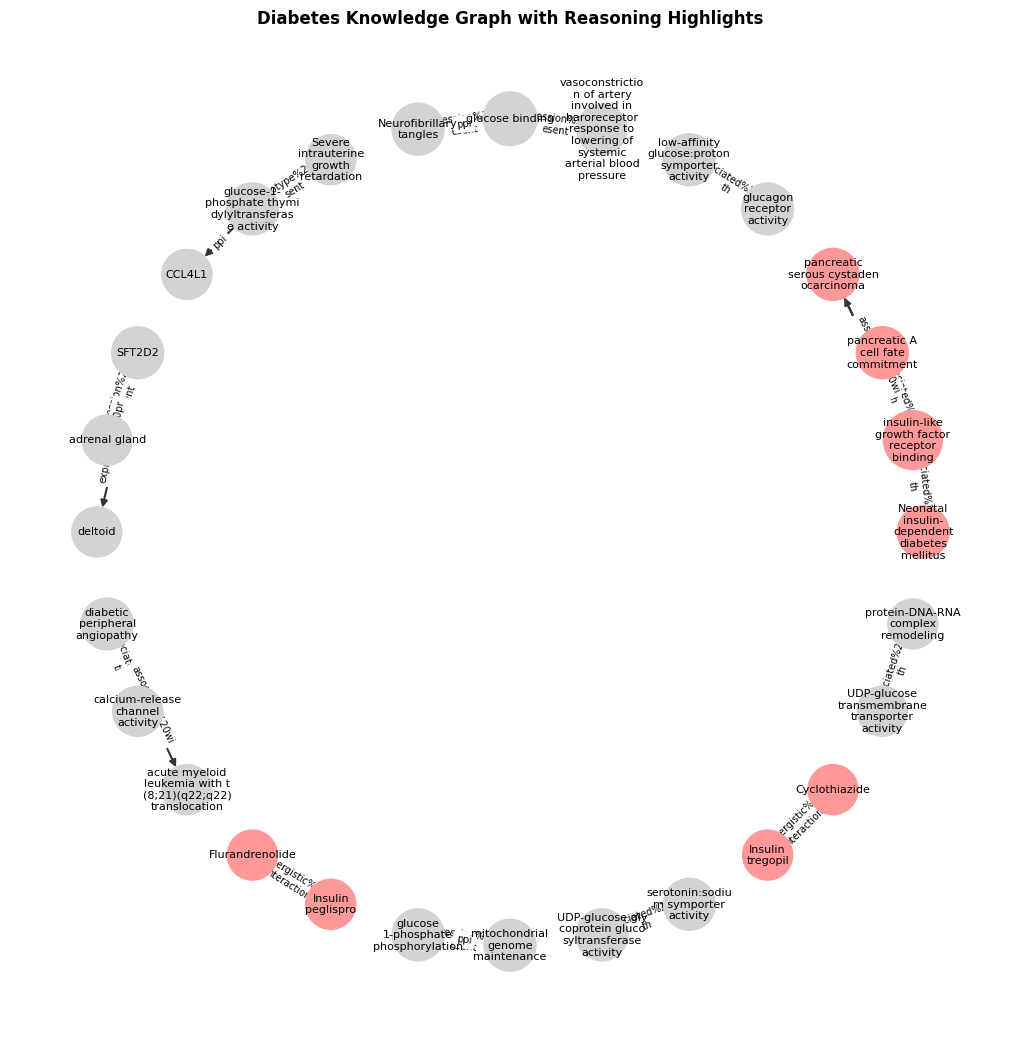


Original Answer:
1. Knowledge Triplet: Complication of diabetes - Diabetic retinopathy is a common complication of diabetes that can lead to vision loss.
2. Knowledge Triplet: Complication of diabetes - Diabetic neuropathy is a complication that affects the nerves, leading to numbness and pain in the extremities.
3. Knowledge Triplet: Complication of diabetes - Diabetic nephropathy is a complication that affects the kidneys, leading to kidney damage and potential failure.

These complications of diabetes are related to insulin resistance because insulin resistance can lead to high levels of glucose in the blood, which can damage blood vessels and nerves over time. This damage can then lead to the development of complications such as retinopathy, neuropathy, and nephropathy.

--- LLM Response ---

The main complications of diabetes include cardiovascular diseases, neuropathy, nephropathy, retinopathy, and increased susceptibility to infections. These complications are related to insuli

In [26]:
# Initialize OpenAI client
client = OpenAI()  # Ensure OPENAI_API_KEY is set in your environment

# Path to your PrimeKG dataset
file_path = "/content/drive/MyDrive/PrimeKG_Data/final_test.json"

# Embedding cache and model
embedding_cache = {}
EMBEDDING_MODEL = "text-embedding-3-small"

def load_primekg_data(file_path):
    """
    Load PrimeKG data from a JSON file.

    Parameters:
    - file_path: Path to the JSON file containing PrimeKG data

    Returns:
    - List of data entries from the JSON file
    """
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        print(f"Successfully loaded {len(data)} entries from {file_path}")
        return data
    except Exception as e:
        print(f"Error loading data: {e}")
        return []

def is_diabetes_related(text):
    """
    Check if text contains diabetes-related terms.

    Parameters:
    - text: Text to check

    Returns:
    - Relevance score (0: not related, 1: secondary relation, 2: primary relation)
    """
    core_diabetes_terms = [
        'diabetes', 'diabetic', 'insulin', 'glucose',
        'type 1 diabetes', 'type 2 diabetes', 't1d', 't2d'
    ]
    secondary_terms = [
        'hyperglycemia', 'hypoglycemia', 'glycemic', 'a1c',
        'hemoglobin a1c', 'gestational diabetes', 'prediabetes',
        'metabolic syndrome', 'pancreatic', 'islet', 'beta cell',
        'metformin', 'glucagon', 'diabetic retinopathy',
        'diabetic nephropathy', 'diabetic neuropathy'
    ]

    text_lower = text.lower()
    for term in core_diabetes_terms:
        if term in text_lower:
            return 2
    for term in secondary_terms:
        if term in text_lower:
            return 1
    return 0

def extract_diabetes_knowledge_graph(data, max_parts=10):
    """
    Extract strongly connected diabetes-related knowledge graph triples from PrimeKG data.

    Parameters:
    - data: List of entries from the PrimeKG JSON file
    - max_parts: Maximum number of parts to include

    Returns:
    - kg: List of diabetes-related knowledge graph triples
    - portion_indices: Dictionary mapping portion names to ranges of triple indices
    """
    all_diabetes_triples = []
    for entry in data:
        triples = entry.get('value', [])
        if not triples:
            continue
        for triple in triples:
            if len(triple) == 3:
                subject, predicate, obj = triple
                subject_score = is_diabetes_related(subject)
                predicate_score = is_diabetes_related(predicate)
                object_score = is_diabetes_related(obj)
                total_score = subject_score + predicate_score + object_score
                if total_score > 0:
                    all_diabetes_triples.append((triple, total_score))

    all_diabetes_triples.sort(key=lambda x: x[1], reverse=True)
    G = nx.Graph()
    for (triple, _) in all_diabetes_triples:
        subject, predicate, obj = triple
        G.add_edge(subject, obj, relation=predicate)

    connected_components = list(nx.connected_components(G))
    connected_components.sort(key=len, reverse=True)
    components_to_use = connected_components[:max_parts]
    nodes_to_keep = set()
    for component in components_to_use:
        nodes_to_keep.update(component)

    filtered_triples = []
    for (triple, score) in all_diabetes_triples:
        subject, predicate, obj = triple
        if subject in nodes_to_keep and obj in nodes_to_keep:
            filtered_triples.append(triple)

    kg = []
    portion_indices = {}
    component_to_triples = defaultdict(list)
    for triple in filtered_triples:
        subject, _, obj = triple
        for i, component in enumerate(components_to_use):
            if subject in component and obj in component:
                component_to_triples[i].append(triple)
                break

    triple_index = 0
    portion_counter = 1
    print("\nStructured Diabetes Knowledge Graph (Focused on Strong Connections):\n")
    for component_idx, triples in sorted(component_to_triples.items()):
        if not triples or portion_counter > max_parts:
            continue
        triples = triples[:20]
        start_index = triple_index
        end_index = start_index + len(triples)
        portion_indices[f"Part {portion_counter}"] = range(start_index, end_index)
        print(f"\n# Part {portion_counter}")
        for triple in triples:
            subject, predicate, obj = triple
            print(f"({subject}) → ({predicate}) → ({obj})")
            kg.append((subject, predicate, obj))
            triple_index += 1
        print("-" * 80)
        portion_counter += 1
        if portion_counter > max_parts:
            break
    return kg, portion_indices

def save_knowledge_graph(kg, output_file="focused_diabetes_kg.txt"):
    """
    Save the knowledge graph to a text file.

    Parameters:
    - kg: List of knowledge graph triples
    - output_file: Name of the output file
    """
    with open(output_file, "w", encoding="utf-8") as f:
        for triple in kg:
            f.write(f"( {triple[0]} , {triple[1]} , {triple[2]} )\n\n")
    print(f"\nFocused Diabetes Knowledge Graph saved as '{output_file}'.")

def perturb_kg_by_removing_parts(kg, parts_to_remove, portion_indices):
    """
    Perturbs the knowledge graph by removing triples from the specified parts.
    """
    indices_to_remove = set()
    for part in parts_to_remove:
        if part in portion_indices:
            indices_to_remove.update(portion_indices[part])
    perturbed_kg = [triple for i, triple in enumerate(kg) if i not in indices_to_remove]
    return perturbed_kg

def calculate_fidelity_metrics(y_true, y_pred, weights, coeff):
    """
    Calculate and print various fidelity metrics for a regression model.
    """
    mse = mean_squared_error(y_true, y_pred, sample_weight=weights)
    r2 = r2_score(y_true, y_pred, sample_weight=weights)
    mae = mean_absolute_error(y_true, y_pred, sample_weight=weights)
    mean_loss_f = np.mean(y_true)
    mean_loss_g = np.mean(y_pred)
    mean_loss = abs(mean_loss_f - mean_loss_g)
    mean_l1 = np.mean(np.abs(y_true - y_pred))
    mean_l2 = np.mean((y_true - y_pred) ** 2)
    n = len(y_true)
    weighted_l1 = np.sum(weights * np.abs(y_true - y_pred)) / n
    weighted_l2 = np.sum(weights * (y_true - y_pred) ** 2) / n
    f_mean = np.average(y_true, weights=weights)
    ss_tot = np.sum(weights * (y_true - f_mean) ** 2)
    ss_res = np.sum(weights * (y_true - y_pred) ** 2)
    weighted_r2 = 1 - ss_res / ss_tot
    p = len(coeff)
    weighted_adj_r2 = 1 - (1 - weighted_r2) * (n - 1) / (n - p - 1)
    print(100 * '-')
    print('Fidelity:')
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"R-squared (R²): {r2}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Loss (Lm): {mean_loss}")
    print(f"Mean L1 Loss: {mean_l1}")
    print(f"Mean L2 Loss: {mean_l2}")
    print(f"Weighted L1 Loss: {weighted_l1}")
    print(f"Weighted L2 Loss: {weighted_l2}")
    print(f"Weighted R-squared (R²ω): {weighted_r2}")
    print(f"Weighted Adjusted R-squared (Rˆ²ω): {weighted_adj_r2}")
    print(100 * '-')

def normalize_text(text):
    """
    Normalize text by removing excessive spaces, normalizing Unicode characters,
    and converting to lowercase.
    """
    text = text.replace("\n", " ").strip()
    text = unicodedata.normalize("NFKC", text)
    text = re.sub(r"\s+", " ", text)
    text = text.lower()
    return text

def get_embedding(text):
    """
    Get embedding for the given text using OpenAI's API.
    """
    text = normalize_text(text)
    if text in embedding_cache:
        return embedding_cache[text]
    try:
        embedding = client.embeddings.create(input=[text], model=EMBEDDING_MODEL).data[0].embedding
        embedding_cache[text] = embedding
        return embedding
    except Exception as e:
        print(f"Error getting embedding for '{text}': {e}")
        return [0] * 1536  # Fallback embedding (dimension of text-embedding-3-small)

def get_answer_and_embedding(question, temp, graph, kg):
    """
    Sends a question to the GraphQAChain and returns the answer and its embedding.
    """
    llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=temp, openai_api_key=os.getenv("OPENAI_API_KEY"))
    chain = GraphQAChain.from_llm(llm, graph=graph, verbose=False)
    try:
        response = chain.run(question)  # Use run for older langchain versions
        original_answer_str = str(response)
    except Exception as e:
        print(f"GraphQAChain failed: {e}. Falling back to triples-based prompt.")
        triples_text = "\n".join([f"{n1} --[{r}]--> {n2}" for n1, r, n2 in kg])
        prompt = f"Knowledge graph triples:\n{triples_text}\n\nQuestion: {question}"
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "You are a helpful assistant analyzing a knowledge graph."},
                {"role": "user", "content": prompt}
            ]
        )
        original_answer_str = response.choices[0].message.content
    original_answer_embedding = get_embedding(original_answer_str)
    return original_answer_str, original_answer_embedding

def wrap_label(label, width=15):
    """
    Wraps labels to fit within a specified width for better visualization.
    """
    return '\n'.join(textwrap.wrap(label, width))

def wrap_text(text, relation, max_words=8):
    """
    Wrap text if it contains more than `max_words` words and append '_explanation' to abstract nodes.

    Parameters:
    - text: Text to wrap
    - relation: Relation type
    - max_words: Maximum number of words before wrapping

    Returns:
    - Wrapped text
    """
    if relation == "abstract":
        words = text.split()
        return f"{text}_explanation" if len(words) > max_words else text
    return text

def build_graph(kg, coeff, part_indices, cmap, norm):
    """
    Helper function to build graph, assign colors, and sizes.
    """
    G = nx.DiGraph()
    for node1, relation, node2 in kg:
        wrapped_node1 = wrap_label(wrap_text(node1, relation))
        wrapped_node2 = wrap_label(wrap_text(node2, relation))
        wrapped_relation = wrap_label(relation)
        G.add_edge(wrapped_node1, wrapped_node2, label=wrapped_relation)

    pos = nx.spring_layout(G, k=8, iterations=200, seed=0)
    node_sizes = [1500 + 100 * G.degree(node) for node in G.nodes()]

    node_colors = []
    for node in G.nodes():
        assigned_color = '#8da0cb'
        for part_name, indices in part_indices.items():
            part_idx = int(part_name.split()[-1]) - 1
            if part_idx < len(coeff):
                coeff_value = coeff[part_idx]
                color = cmap(norm(coeff_value))
                if any(i < len(kg) and (wrap_label(wrap_text(kg[i][0], kg[i][1])) == node or
                       wrap_label(wrap_text(kg[i][2], kg[i][1])) == node)
                       for i in indices):
                    assigned_color = color
                    break
        node_colors.append(assigned_color)

    edge_colors = []
    for u, v in G.edges():
        assigned_color = 'gray'
        edge_idx = None
        for i, (node1, relation, node2) in enumerate(kg):
            if (wrap_label(wrap_text(node1, relation)) == u and
                wrap_label(wrap_text(node2, relation)) == v):
                edge_idx = i
                break
        if edge_idx is not None:
            for part_name, indices in part_indices.items():
                if edge_idx in indices:
                    part_idx = int(part_name.split()[-1]) - 1
                    if part_idx < len(coeff):
                        coeff_value = coeff[part_idx]
                        color = cmap(norm(coeff_value))
                        assigned_color = color
                        break
        edge_colors.append(assigned_color)

    return G, pos, node_sizes, node_colors, edge_colors

def plot_knowledge_graph_explainability(kg, part_indices, coeff):
    """
    Improved visualization of a knowledge graph with explainability features.
    """
    cmap = mcolors.LinearSegmentedColormap.from_list('red_blue', ['blue', '#d3d3d3', 'red'])
    norm = mcolors.Normalize(vmin=-1, vmax=1)

    G, pos, node_sizes, node_colors, edge_colors = build_graph(kg, coeff, part_indices, cmap, norm)
    fig, ax = plt.subplots(figsize=(10, 10), dpi=100)

    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, ax=ax)
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=1.5, ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=6, ax=ax)
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6, ax=ax)

    ax.set_title("Knowledge Graph Explainability", fontsize=14)
    ax.axis('off')

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    fig.colorbar(sm, ax=ax, orientation='horizontal', label='Importance Coefficients', fraction=0.03, pad=0.05)

    plt.savefig('knowledge_graph_explainability.png', bbox_inches='tight')
    plt.close()

def plot_actual_vs_predicted(y_true, y_pred, weights=None):
    """
    Plot actual vs. predicted values with an optional weight normalization for point sizes.
    """
    r2 = r2_score(y_true, y_pred, sample_weight=weights)
    if weights is not None:
        normalized_weights = np.array(weights) / np.max(weights) * 100
    else:
        normalized_weights = 50

    fig, ax = plt.subplots()
    ax.scatter(y_true, y_pred, s=normalized_weights, label='Data points', alpha=0.6)
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='Perfect Prediction Line')
    ax.set_xlim([min_val, max_val])
    ax.set_ylim([min_val, max_val])
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_title(f'Actual vs. Predicted Values\nR²: {r2:.2f}')
    ax.legend()
    plt.savefig('actual_vs_predicted.png', bbox_inches='tight')
    plt.close()

def extract_entities_relations(question):
    """
    Extracts entities and key relations (verbs) from the question using spaCy.
    """
    try:
        nlp = spacy.load("en_core_web_sm")
    except Exception as e:
        print(f"Error loading spaCy model: {e}. Install with: python -m spacy download en_core_web_sm")
        return [], []
    doc = nlp(question)
    entities = [ent.text for ent in doc.ents]
    # Add simple keyword matching for diabetes-related terms
    diabetes_keywords = [
        'diabetes', 'insulin', 'glucose', 'complications', 'insulin resistance',
        'diabetic', 'hyperglycemia', 'hypoglycemia', 'metformin', 'glucagon'
    ]
    for token in doc:
        if token.text.lower() in diabetes_keywords and token.text not in entities:
            entities.append(token.text)
    relations = [token.lemma_ for token in doc if token.pos_ == "VERB"]
    print(f"\nExtracted entities: {entities}")
    print(f"Extracted relations: {relations}")
    return entities, relations

def generate_chain_of_thought(kg, question):
    """
    Generates a reasoning chain by identifying relevant entities in the knowledge graph.
    """
    print("\n--- Reasoning Chain ---")
    entities, relations = extract_entities_relations(question)
    reasoning_chain = []
    relevant_nodes = set()

    for entity in entities:
        for triple in kg:
            node1, relation, node2 = triple
            if entity.lower() in node1.lower() or entity.lower() in node2.lower():
                reasoning_chain.append(triple)
                relevant_nodes.update([node1, node2])

    if not reasoning_chain:
        print("No relevant triples found for the question. Using all triples as fallback.")
        reasoning_chain = kg[:5]  # Use first 5 triples as fallback
        relevant_nodes.update([t[0] for t in reasoning_chain] + [t[2] for t in reasoning_chain])

    for step in reasoning_chain:
        print(f"{step[0]} --[{step[1]}]--> {step[2]}")

    print(f"Number of triples in reasoning chain: {len(reasoning_chain)}")
    wrapped_nodes = {wrap_label(wrap_text(node, '')) for node in relevant_nodes}
    return wrapped_nodes, reasoning_chain

def visualize_graph_circular(kg, highlighted_nodes, reasoning_chain):
    """
    Visualize the knowledge graph with a circular layout and optimized label spacing.
    """
    G = nx.DiGraph()
    for node1, relation, node2 in kg:
        wrapped_node1 = wrap_label(wrap_text(node1, relation))
        wrapped_node2 = wrap_label(wrap_text(node2, relation))
        G.add_edge(wrapped_node1, wrapped_node2, label=wrap_label(relation))

    pos = nx.circular_layout(G, scale=4)  # Increased scale for better spacing
    node_sizes = [1200 + 100 * G.degree(node) for node in G.nodes()]
    highlight_node_colors = ['#ff9999' if node in highlighted_nodes else '#d3d3d3' for node in G.nodes()]
    edge_colors = ['#333333' for _ in G.edges()]  # Darker edges for clarity

    plt.figure(figsize=(10, 10))  # Increased figure size
    nx.draw(G, pos, node_size=node_sizes, node_color=highlight_node_colors,
            edge_color=edge_colors, width=1.5, with_labels=True, arrows=True, font_size=8)
    edge_labels = {edge: G.edges[edge]['label'] for edge in G.edges()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7, label_pos=0.5)

    plt.title("Diabetes Knowledge Graph with Reasoning Highlights", fontsize=12, fontweight='bold')
    try:
        plt.savefig('knowledge_graph_circular_optimized.png', bbox_inches='tight', dpi=150)
        print("\nCircular graph saved as 'knowledge_graph_circular_optimized.png'")
    except Exception as e:
        print(f"Error saving circular graph: {e}")
    plt.show()  # Display the plot inline in Colab
    # Removed plt.close() to allow inline display

def format_triples_for_prompt(reasoning_chain, question):
    """
    Formats the extracted triples into a readable structure for LLM input.
    """
    prompt = "The following triples represent relevant knowledge about the question:\n\n"
    for node1, relation, node2 in reasoning_chain:
        prompt += f"- {node1} --[{relation}]--> {node2}\n"
    prompt += "\nBased on the above information, answer the question:\n"
    prompt += question
    return prompt

def get_chat_response(prompt):
    """
    Get a response from the OpenAI Chat API.
    """
    try:
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "You are a helpful assistant analyzing a knowledge graph."},
                {"role": "user", "content": prompt}
            ]
        )
        return response.choices[0].message.content
    except Exception as e:
        print(f"Error in get_chat_response: {e}")
        return "Unable to generate response."

def main():
    # Load data from PrimeKG JSON file
    primekg_data = load_primekg_data(file_path)

    if not primekg_data:
        print("No data loaded. Please check the file path.")
        return

    # Extract diabetes-related knowledge graph
    kg, portion_indices = extract_diabetes_knowledge_graph(primekg_data, max_parts=10)

    if not kg:
        print("No diabetes-related information found in the dataset.")
        return

    print(f"\nFound {len(kg)} strongly connected diabetes-related triples in the dataset.")
    print(f"Organized into {len(portion_indices)} parts.")

    # Print portion indices
    print("\nPortion Indices:\n")
    for part, index_range in portion_indices.items():
        print(f"{part}: {index_range}")

    # Save knowledge graph
    save_knowledge_graph(kg)

    # Print the final KG
    print("\nFinal Focused Diabetes Knowledge Graph List:\n")
    for triple in kg:
        print("(", triple[0], ",", triple[1], ", ", triple[2], ")")

    # Instantiate the graph for LangChain
    graph = NetworkxEntityGraph()

    # Build the graph using GraphDocument
    nodes = {}
    relationships = []
    # Create a source Document with page_content summarizing the triples
    triples_text = "\n".join([f"{n1} --[{r}]--> {n2}" for n1, r, n2 in kg])
    source_doc = Document(page_content=triples_text, metadata={"source": "PrimeKG"})

    for node1, relation, node2 in kg:
        if node1 not in nodes:
            nodes[node1] = Node(id=node1, type="Entity")
        if node2 not in nodes:
            nodes[node2] = Node(id=node2, type="Entity")
        relationships.append(Relationship(source=nodes[node1], target=nodes[node2], type=relation))

    graph_doc = GraphDocument(nodes=list(nodes.values()), relationships=relationships, source=source_doc)
    for node in graph_doc.nodes:
        graph.add_node(node.id)
    for rel in graph_doc.relationships:
        triple = KnowledgeTriple(subject=rel.source.id, predicate=rel.type, object_=rel.target.id)
        graph.add_triple(triple)

    # Define a sample question
    question = "What are the main complications of diabetes and how are they related to insulin resistance?"

    # Define the original vector for perturbation experiments
    part_names = list(portion_indices.keys())
    original = np.ones(len(part_names))
    original = original.reshape(1, -1)

    # Generate chain of thought reasoning
    highlighted_nodes, reasoning_chain = generate_chain_of_thought(kg, question)

    # Visualize the graph with reasoning highlights
    visualize_graph_circular(kg, highlighted_nodes, reasoning_chain)

    # Get an answer using the knowledge graph
    temp = 0
    original_answer_str, original_answer_embedding = get_answer_and_embedding(question, temp, graph, kg)
    print("\nOriginal Answer:")
    print(original_answer_str)

    # Format the extracted triples for the prompt
    structured_prompt = format_triples_for_prompt(reasoning_chain, question)

    # Get response from LLM
    final_answer = get_chat_response(structured_prompt)
    print("\n--- LLM Response ---\n")
    print(final_answer)

if __name__ == "__main__":
    main()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Successfully loaded 17074 entries from /content/drive/MyDrive/PrimeKG_Data/final_test.json

Structured Diabetes Knowledge Graph (Focused on Strong Connections):


# Part 1
(Neonatal insulin-dependent diabetes mellitus) → (associated%20with) → (insulin-like growth factor receptor binding)
(insulin-like growth factor receptor binding) → (ppi) → (Neonatal insulin-dependent diabetes mellitus)
(Neonatal insulin-dependent diabetes mellitus) → (associated%20with) → (insulin-like growth factor receptor binding)
(insulin-like growth factor receptor binding) → (ppi) → (Neonatal insulin-dependent diabetes mellitus)
(Neonatal insulin-dependent diabetes mellitus) → (ppi) → (insulin-like growth factor receptor binding)
(insulin-like growth factor receptor binding) → (associated%20with) → (Neonatal insulin-dependent diabetes mellitus)
(Neonatal insulin-dependent diabetes me

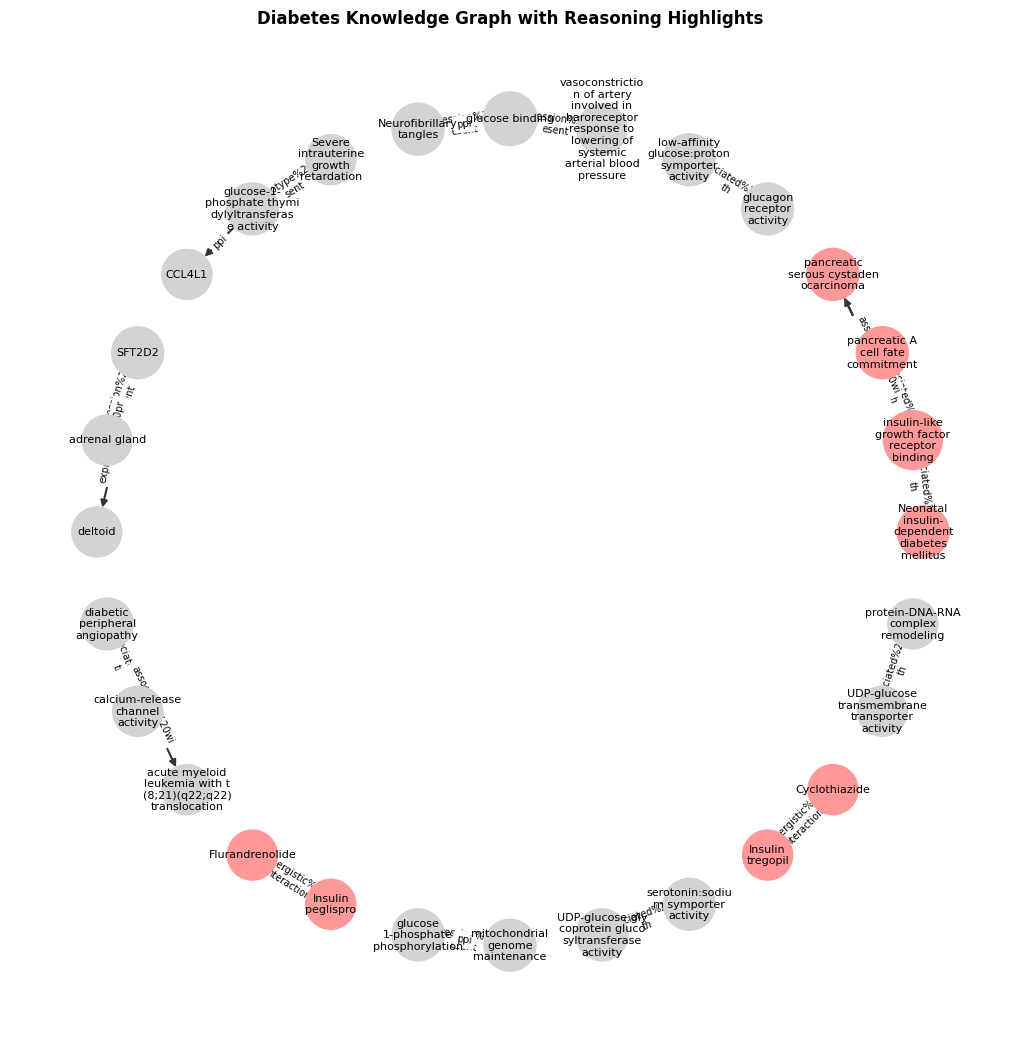


Original Answer:
1. Knowledge Triplet: Insulin resistance is a condition where the body's cells do not respond properly to insulin, leading to high blood sugar levels.
2. Knowledge Triplet: The main complications of diabetes include cardiovascular disease, kidney disease, nerve damage, and eye problems.
3. Knowledge Triplet: Insulin resistance is a key factor in the development of type 2 diabetes, which can lead to these complications over time.

Answer: The main complications of diabetes, such as cardiovascular disease, kidney disease, nerve damage, and eye problems, are related to insulin resistance because insulin resistance is a key factor in the development of type 2 diabetes, which can lead to these complications over time.

--- LLM Response (Original) ---

The main complications of diabetes include cardiovascular diseases, neuropathy, retinopathy, and nephropathy. These complications are often related to insulin resistance, where the body's cells become less responsive to insul

In [28]:
# Mount Google Drive
drive.mount('/content/drive')

# Initialize OpenAI client
client = OpenAI()  # Ensure OPENAI_API_KEY is set in your environment

# Path to your PrimeKG dataset and output directory
file_path = "/content/drive/MyDrive/PrimeKG_Data/final_test.json"
output_dir = "/content/drive/MyDrive/PrimeKG_Data/"

# Embedding cache and model
embedding_cache = {}
EMBEDDING_MODEL = "text-embedding-3-small"

def load_primekg_data(file_path):
    """
    Load PrimeKG data from a JSON file.

    Parameters:
    - file_path: Path to the JSON file containing PrimeKG data

    Returns:
    - List of data entries from the JSON file
    """
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        print(f"Successfully loaded {len(data)} entries from {file_path}")
        return data
    except Exception as e:
        print(f"Error loading data: {e}")
        return []

def is_diabetes_related(text):
    """
    Check if text contains diabetes-related terms.

    Parameters:
    - text: Text to check

    Returns:
    - Relevance score (0: not related, 1: secondary relation, 2: primary relation)
    """
    core_diabetes_terms = [
        'diabetes', 'diabetic', 'insulin', 'glucose',
        'type 1 diabetes', 'type 2 diabetes', 't1d', 't2d'
    ]
    secondary_terms = [
        'hyperglycemia', 'hypoglycemia', 'glycemic', 'a1c',
        'hemoglobin a1c', 'gestational diabetes', 'prediabetes',
        'metabolic syndrome', 'pancreatic', 'islet', 'beta cell',
        'metformin', 'glucagon', 'diabetic retinopathy',
        'diabetic nephropathy', 'diabetic neuropathy'
    ]

    text_lower = text.lower()
    for term in core_diabetes_terms:
        if term in text_lower:
            return 2
    for term in secondary_terms:
        if term in text_lower:
            return 1
    return 0

def extract_diabetes_knowledge_graph(data, max_parts=10):
    """
    Extract strongly connected diabetes-related knowledge graph triples from PrimeKG data.

    Parameters:
    - data: List of entries from the PrimeKG JSON file
    - max_parts: Maximum number of parts to include

    Returns:
    - kg: List of diabetes-related knowledge graph triples
    - portion_indices: Dictionary mapping portion names to ranges of triple indices
    """
    all_diabetes_triples = []
    for entry in data:
        triples = entry.get('value', [])
        if not triples:
            continue
        for triple in triples:
            if len(triple) == 3:
                subject, predicate, obj = triple
                subject_score = is_diabetes_related(subject)
                predicate_score = is_diabetes_related(predicate)
                object_score = is_diabetes_related(obj)
                total_score = subject_score + predicate_score + object_score
                if total_score > 0:
                    all_diabetes_triples.append((triple, total_score))

    all_diabetes_triples.sort(key=lambda x: x[1], reverse=True)
    G = nx.Graph()
    for (triple, _) in all_diabetes_triples:
        subject, predicate, obj = triple
        G.add_edge(subject, obj, relation=predicate)

    connected_components = list(nx.connected_components(G))
    connected_components.sort(key=len, reverse=True)
    components_to_use = connected_components[:max_parts]
    nodes_to_keep = set()
    for component in components_to_use:
        nodes_to_keep.update(component)

    filtered_triples = []
    for (triple, score) in all_diabetes_triples:
        subject, predicate, obj = triple
        if subject in nodes_to_keep and obj in nodes_to_keep:
            filtered_triples.append(triple)

    kg = []
    portion_indices = {}
    component_to_triples = defaultdict(list)
    for triple in filtered_triples:
        subject, _, obj = triple
        for i, component in enumerate(components_to_use):
            if subject in component and obj in component:
                component_to_triples[i].append(triple)
                break

    triple_index = 0
    portion_counter = 1
    print("\nStructured Diabetes Knowledge Graph (Focused on Strong Connections):\n")
    for component_idx, triples in sorted(component_to_triples.items()):
        if not triples or portion_counter > max_parts:
            continue
        triples = triples[:20]
        start_index = triple_index
        end_index = start_index + len(triples)
        portion_indices[f"Part {portion_counter}"] = range(start_index, end_index)
        print(f"\n# Part {portion_counter}")
        for triple in triples:
            subject, predicate, obj = triple
            print(f"({subject}) → ({predicate}) → ({obj})")
            kg.append((subject, predicate, obj))
            triple_index += 1
        print("-" * 80)
        portion_counter += 1
        if portion_counter > max_parts:
            break
    return kg, portion_indices

def save_knowledge_graph(kg, output_file=os.path.join(output_dir, "focused_diabetes_kg.txt")):
    """
    Save the knowledge graph to a text file in the specified Google Drive directory.

    Parameters:
    - kg: List of knowledge graph triples
    - output_file: Name of the output file (default: in output_dir)
    """
    try:
        with open(output_file, "w", encoding="utf-8") as f:
            for triple in kg:
                f.write(f"( {triple[0]} , {triple[1]} , {triple[2]} )\n\n")
        print(f"\nFocused Diabetes Knowledge Graph saved as '{output_file}'.")
    except Exception as e:
        print(f"Error saving knowledge graph to '{output_file}': {e}")

def perturb_kg_by_removing_parts(kg, parts_to_remove, portion_indices):
    """
    Perturbs the knowledge graph by removing triples from the specified parts.

    Parameters:
    - kg: List of knowledge graph triples
    - parts_to_remove: List of part names to remove
    - portion_indices: Dictionary mapping part names to triple indices

    Returns:
    - perturbed_kg: List of triples after removing specified parts
    """
    indices_to_remove = set()
    for part in parts_to_remove:
        if part in portion_indices:
            indices_to_remove.update(portion_indices[part])
    perturbed_kg = [triple for i, triple in enumerate(kg) if i not in indices_to_remove]
    return perturbed_kg

def calculate_fidelity_metrics(y_true, y_pred, weights, coeff):
    """
    Calculate and print various fidelity metrics for a regression model.
    """
    mse = mean_squared_error(y_true, y_pred, sample_weight=weights)
    r2 = r2_score(y_true, y_pred, sample_weight=weights)
    mae = mean_absolute_error(y_true, y_pred, sample_weight=weights)
    mean_loss_f = np.mean(y_true)
    mean_loss_g = np.mean(y_pred)
    mean_loss = abs(mean_loss_f - mean_loss_g)
    mean_l1 = np.mean(np.abs(y_true - y_pred))
    mean_l2 = np.mean((y_true - y_pred) ** 2)
    n = len(y_true)
    weighted_l1 = np.sum(weights * np.abs(y_true - y_pred)) / n
    weighted_l2 = np.sum(weights * (y_true - y_pred) ** 2) / n
    f_mean = np.average(y_true, weights=weights)
    ss_tot = np.sum(weights * (y_true - f_mean) ** 2)
    ss_res = np.sum(weights * (y_true - y_pred) ** 2)
    weighted_r2 = 1 - ss_res / ss_tot
    p = len(coeff)
    weighted_adj_r2 = 1 - (1 - weighted_r2) * (n - 1) / (n - p - 1)
    print(100 * '-')
    print('Fidelity:')
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"R-squared (R²): {r2}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Loss (Lm): {mean_loss}")
    print(f"Mean L1 Loss: {mean_l1}")
    print(f"Mean L2 Loss: {mean_l2}")
    print(f"Weighted L1 Loss: {weighted_l1}")
    print(f"Weighted L2 Loss: {weighted_l2}")
    print(f"Weighted R-squared (R²ω): {weighted_r2}")
    print(f"Weighted Adjusted R-squared (Rˆ²ω): {weighted_adj_r2}")
    print(100 * '-')

def normalize_text(text):
    """
    Normalize text by removing excessive spaces, normalizing Unicode characters,
    and converting to lowercase.
    """
    text = text.replace("\n", " ").strip()
    text = unicodedata.normalize("NFKC", text)
    text = re.sub(r"\s+", " ", text)
    text = text.lower()
    return text

def get_embedding(text):
    """
    Get embedding for the given text using OpenAI's API.
    """
    text = normalize_text(text)
    if text in embedding_cache:
        return embedding_cache[text]
    try:
        embedding = client.embeddings.create(input=[text], model=EMBEDDING_MODEL).data[0].embedding
        embedding_cache[text] = embedding
        return embedding
    except Exception as e:
        print(f"Error getting embedding for '{text}': {e}")
        return [0] * 1536  # Fallback embedding (dimension of text-embedding-3-small)

def get_answer_and_embedding(question, temp, graph, kg):
    """
    Sends a question to the GraphQAChain and returns the answer and its embedding.
    """
    llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=temp, openai_api_key=os.getenv("OPENAI_API_KEY"))
    chain = GraphQAChain.from_llm(llm, graph=graph, verbose=False)
    try:
        response = chain.run(question)  # Use run for older langchain versions
        original_answer_str = str(response)
    except Exception as e:
        print(f"GraphQAChain failed: {e}. Falling back to triples-based prompt.")
        triples_text = "\n".join([f"{n1} --[{r}]--> {n2}" for n1, r, n2 in kg])
        prompt = f"Knowledge graph triples:\n{triples_text}\n\nQuestion: {question}"
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "You are a helpful assistant analyzing a knowledge graph."},
                {"role": "user", "content": prompt}
            ]
        )
        original_answer_str = response.choices[0].message.content
    original_answer_embedding = get_embedding(original_answer_str)
    return original_answer_str, original_answer_embedding

def wrap_label(label, width=15):
    """
    Wraps labels to fit within a specified width for better visualization.
    """
    return '\n'.join(textwrap.wrap(label, width))

def wrap_text(text, relation, max_words=8):
    """
    Wrap text if it contains more than `max_words` words and append '_explanation' to abstract nodes.

    Parameters:
    - text: Text to wrap
    - relation: Relation type
    - max_words: Maximum number of words before wrapping

    Returns:
    - Wrapped text
    """
    if relation == "abstract":
        words = text.split()
        return f"{text}_explanation" if len(words) > max_words else text
    return text

def build_graph(kg, coeff, part_indices, cmap, norm):
    """
    Helper function to build graph, assign colors, and sizes.
    """
    G = nx.DiGraph()
    for node1, relation, node2 in kg:
        wrapped_node1 = wrap_label(wrap_text(node1, relation))
        wrapped_node2 = wrap_label(wrap_text(node2, relation))
        wrapped_relation = wrap_label(relation)
        G.add_edge(wrapped_node1, wrapped_node2, label=wrapped_relation)

    pos = nx.spring_layout(G, k=8, iterations=200, seed=0)
    node_sizes = [1500 + 100 * G.degree(node) for node in G.nodes()]

    node_colors = []
    for node in G.nodes():
        assigned_color = '#8da0cb'
        for part_name, indices in part_indices.items():
            part_idx = int(part_name.split()[-1]) - 1
            if part_idx < len(coeff):
                coeff_value = coeff[part_idx]
                color = cmap(norm(coeff_value))
                if any(i < len(kg) and (wrap_label(wrap_text(kg[i][0], kg[i][1])) == node or
                       wrap_label(wrap_text(kg[i][2], kg[i][1])) == node)
                       for i in indices):
                    assigned_color = color
                    break
        node_colors.append(assigned_color)

    edge_colors = []
    for u, v in G.edges():
        assigned_color = 'gray'
        edge_idx = None
        for i, (node1, relation, node2) in enumerate(kg):
            if (wrap_label(wrap_text(node1, relation)) == u and
                wrap_label(wrap_text(node2, relation)) == v):
                edge_idx = i
                break
        if edge_idx is not None:
            for part_name, indices in part_indices.items():
                if edge_idx in indices:
                    part_idx = int(part_name.split()[-1]) - 1
                    if part_idx < len(coeff):
                        coeff_value = coeff[part_idx]
                        color = cmap(norm(coeff_value))
                        assigned_color = color
                        break
        edge_colors.append(assigned_color)

    return G, pos, node_sizes, node_colors, edge_colors

def plot_knowledge_graph_explainability(kg, part_indices, coeff):
    """
    Improved visualization of a knowledge graph with explainability features.
    """
    cmap = mcolors.LinearSegmentedColormap.from_list('red_blue', ['blue', '#d3d3d3', 'red'])
    norm = mcolors.Normalize(vmin=-1, vmax=1)

    G, pos, node_sizes, node_colors, edge_colors = build_graph(kg, coeff, part_indices, cmap, norm)
    fig, ax = plt.subplots(figsize=(10, 10), dpi=100)

    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, ax=ax)
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=1.5, ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=6, ax=ax)
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6, ax=ax)

    ax.set_title("Knowledge Graph Explainability", fontsize=14)
    ax.axis('off')

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    fig.colorbar(sm, ax=ax, orientation='horizontal', label='Importance Coefficients', fraction=0.03, pad=0.05)

    output_file = os.path.join(output_dir, 'knowledge_graph_explainability.png')
    try:
        plt.savefig(output_file, bbox_inches='tight')
        print(f"Explainability graph saved as '{output_file}'")
    except Exception as e:
        print(f"Error saving explainability graph to '{output_file}': {e}")
    plt.close()

def plot_actual_vs_predicted(y_true, y_pred, weights=None):
    """
    Plot actual vs. predicted values with an optional weight normalization for point sizes.
    """
    r2 = r2_score(y_true, y_pred, sample_weight=weights)
    if weights is not None:
        normalized_weights = np.array(weights) / np.max(weights) * 100
    else:
        normalized_weights = 50

    fig, ax = plt.subplots()
    ax.scatter(y_true, y_pred, s=normalized_weights, label='Data points', alpha=0.6)
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='Perfect Prediction Line')
    ax.set_xlim([min_val, max_val])
    ax.set_ylim([min_val, max_val])
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_title(f'Actual vs. Predicted Values\nR²: {r2:.2f}')
    ax.legend()

    output_file = os.path.join(output_dir, 'actual_vs_predicted.png')
    try:
        plt.savefig(output_file, bbox_inches='tight')
        print(f"Actual vs Predicted plot saved as '{output_file}'")
    except Exception as e:
        print(f"Error saving actual vs predicted plot to '{output_file}': {e}")
    plt.close()

def extract_entities_relations(question):
    """
    Extracts entities and key relations (verbs) from the question using spaCy.
    """
    try:
        nlp = spacy.load("en_core_web_sm")
    except Exception as e:
        print(f"Error loading spaCy model: {e}. Install with: python -m spacy download en_core_web_sm")
        return [], []
    doc = nlp(question)
    entities = [ent.text for ent in doc.ents]
    # Add simple keyword matching for diabetes-related terms
    diabetes_keywords = [
        'diabetes', 'insulin', 'glucose', 'complications', 'insulin resistance',
        'diabetic', 'hyperglycemia', 'hypoglycemia', 'metformin', 'glucagon'
    ]
    for token in doc:
        if token.text.lower() in diabetes_keywords and token.text not in entities:
            entities.append(token.text)
    relations = [token.lemma_ for token in doc if token.pos_ == "VERB"]
    print(f"\nExtracted entities: {entities}")
    print(f"Extracted relations: {relations}")
    return entities, relations

def generate_chain_of_thought(kg, question):
    """
    Generates a reasoning chain by identifying relevant entities in the knowledge graph.
    """
    print("\n--- Reasoning Chain ---")
    entities, relations = extract_entities_relations(question)
    reasoning_chain = []
    relevant_nodes = set()

    for entity in entities:
        for triple in kg:
            node1, relation, node2 = triple
            if entity.lower() in node1.lower() or entity.lower() in node2.lower():
                reasoning_chain.append(triple)
                relevant_nodes.update([node1, node2])

    if not reasoning_chain:
        print("No relevant triples found for the question. Using all triples as fallback.")
        reasoning_chain = kg[:5]  # Use first 5 triples as fallback
        relevant_nodes.update([t[0] for t in reasoning_chain] + [t[2] for t in reasoning_chain])

    for step in reasoning_chain:
        print(f"{step[0]} --[{step[1]}]--> {step[2]}")

    print(f"Number of triples in reasoning chain: {len(reasoning_chain)}")
    wrapped_nodes = {wrap_label(wrap_text(node, '')) for node in relevant_nodes}
    return wrapped_nodes, reasoning_chain

def visualize_graph_circular(kg, highlighted_nodes, reasoning_chain):
    """
    Visualize the knowledge graph with a circular layout and optimized label spacing.
    """
    G = nx.DiGraph()
    for node1, relation, node2 in kg:
        wrapped_node1 = wrap_label(wrap_text(node1, relation))
        wrapped_node2 = wrap_label(wrap_text(node2, relation))
        G.add_edge(wrapped_node1, wrapped_node2, label=wrap_label(relation))

    pos = nx.circular_layout(G, scale=4)  # Increased scale for better spacing
    node_sizes = [1200 + 100 * G.degree(node) for node in G.nodes()]
    highlight_node_colors = ['#ff9999' if node in highlighted_nodes else '#d3d3d3' for node in G.nodes()]
    edge_colors = ['#333333' for _ in G.edges()]  # Darker edges for clarity

    plt.figure(figsize=(10, 10))  # Increased figure size
    nx.draw(G, pos, node_size=node_sizes, node_color=highlight_node_colors,
            edge_color=edge_colors, width=1.5, with_labels=True, arrows=True, font_size=8)
    edge_labels = {edge: G.edges[edge]['label'] for edge in G.edges()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7, label_pos=0.5)

    plt.title("Diabetes Knowledge Graph with Reasoning Highlights", fontsize=12, fontweight='bold')
    output_file = os.path.join(output_dir, 'knowledge_graph_circular_optimized.png')
    try:
        plt.savefig(output_file, bbox_inches='tight', dpi=150)
        print(f"\nCircular graph saved as '{output_file}'")
    except Exception as e:
        print(f"Error saving circular graph to '{output_file}': {e}")
    plt.show()  # Display the plot inline in Colab

def format_triples_for_prompt(reasoning_chain, question):
    """
    Formats the extracted triples into a readable structure for LLM input.

    Parameters:
    - reasoning_chain: List of triples (node1, relation, node2)
    - question: The question to append to the prompt

    Returns:
    - Formatted prompt string
    """
    if not reasoning_chain:
        return "No relevant triples extracted from the knowledge graph.\n\nQuestion: " + question

    prompt = "The following triples represent relevant knowledge about the question:\n\n"
    for triple in reasoning_chain:
        if isinstance(triple, (list, tuple)) and len(triple) == 3:
            prompt += f"- {triple[0]} --[{triple[1]}]--> {triple[2]}\n"

    prompt += "\nBased on the above information, answer the question:\n"
    prompt += question
    return prompt

def get_chat_response(prompt):
    """
    Get a response from the OpenAI Chat API.
    """
    try:
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "You are a helpful assistant analyzing a knowledge graph."},
                {"role": "user", "content": prompt}
            ]
        )
        return response.choices[0].message.content
    except Exception as e:
        print(f"Error in get_chat_response: {e}")
        return "Unable to generate response."

def main():
    # Load data from PrimeKG JSON file
    primekg_data = load_primekg_data(file_path)

    if not primekg_data:
        print("No data loaded. Please check the file path.")
        return

    # Extract diabetes-related knowledge graph
    kg, portion_indices = extract_diabetes_knowledge_graph(primekg_data, max_parts=10)

    if not kg:
        print("No diabetes-related information found in the dataset.")
        return

    print(f"\nFound {len(kg)} strongly connected diabetes-related triples in the dataset.")
    print(f"Organized into {len(portion_indices)} parts.")

    # Print portion indices
    print("\nPortion Indices:\n")
    for part, index_range in portion_indices.items():
        print(f"{part}: {index_range}")

    # Save knowledge graph
    save_knowledge_graph(kg)

    # Print the final KG
    print("\nFinal Focused Diabetes Knowledge Graph List:\n")
    for triple in kg:
        print("(", triple[0], ",", triple[1], ", ", triple[2], ")")

    # Instantiate the graph for LangChain
    graph = NetworkxEntityGraph()

    # Build the graph using GraphDocument
    nodes = {}
    relationships = []
    # Create a source Document with page_content summarizing the triples
    triples_text = "\n".join([f"{n1} --[{r}]--> {n2}" for n1, r, n2 in kg])
    source_doc = Document(page_content=triples_text, metadata={"source": "PrimeKG"})

    for node1, relation, node2 in kg:
        if node1 not in nodes:
            nodes[node1] = Node(id=node1, type="Entity")
        if node2 not in nodes:
            nodes[node2] = Node(id=node2, type="Entity")
        relationships.append(Relationship(source=nodes[node1], target=nodes[node2], type=relation))

    graph_doc = GraphDocument(nodes=list(nodes.values()), relationships=relationships, source=source_doc)
    for node in graph_doc.nodes:
        graph.add_node(node.id)
    for rel in graph_doc.relationships:
        triple = KnowledgeTriple(subject=rel.source.id, predicate=rel.type, object_=rel.target.id)
        graph.add_triple(triple)

    # Define a sample question
    question = "What are the main complications of diabetes and how are they related to insulin resistance?"

    # Define the original vector for perturbation experiments
    part_names = list(portion_indices.keys())
    original = np.ones(len(part_names))
    original = original.reshape(1, -1)

    # Generate chain of thought reasoning
    highlighted_nodes, reasoning_chain = generate_chain_of_thought(kg, question)

    # Visualize the graph with reasoning highlights
    visualize_graph_circular(kg, highlighted_nodes, reasoning_chain)

    # Get original answer and embedding
    temp = 0
    original_answer_str, original_answer_embedding = get_answer_and_embedding(question, temp, graph, kg)
    print("\nOriginal Answer:")
    print(original_answer_str)

    # Format the extracted triples for the original prompt
    structured_prompt = format_triples_for_prompt(reasoning_chain, question)

    # Get response from LLM (original answer)
    original_answer = get_chat_response(structured_prompt)
    print("\n--- LLM Response (Original) ---\n")
    print(original_answer)

    # Perturbation analysis
    similarities_cosine = []
    similarities_wd = []
    generated_embeddings = []
    perturbations_vect2 = []
    perturbation_texts = []

    # Loop for perturbations
    for i in range(20):
        perturbation_vector = original.copy().flatten()

        # Randomly choose parts to remove
        num_parts_to_remove = random.randint(1, len(part_names))
        parts_to_remove_indices = random.sample(range(len(part_names)), num_parts_to_remove)

        # Set selected parts to 0
        for part_idx in parts_to_remove_indices:
            perturbation_vector[part_idx] = 0

        perturbations_vect2.append(perturbation_vector)

        # Perturb the KG
        parts_to_remove = [part_names[idx] for idx in parts_to_remove_indices]
        perturbed_kg = perturb_kg_by_removing_parts(kg, parts_to_remove, portion_indices)

        # Generate extracted triples from perturbed KG
        _, perturbed_reasoning_chain = generate_chain_of_thought(perturbed_kg, question)

        if not perturbed_reasoning_chain:
            perturbed_reasoning_chain = []  # Ensure it's an empty list to avoid errors

        # Format extracted triples for LLM input
        structured_prompt = format_triples_for_prompt(perturbed_reasoning_chain, question)

        # Get response from LLM
        temp_response = get_chat_response(structured_prompt)

        # Handle None or empty response
        if not temp_response or temp_response.strip() == "":
            temp_response = "No meaningful response generated."
        perturbation_texts.append(temp_response)

        # Get embedding for the perturbed response
        try:
            temp_response_embedding = get_embedding(temp_response)
            generated_embeddings.append(temp_response_embedding)
        except Exception as e:
            print(f"Error generating embedding for response: {temp_response}")
            print(f"Exception: {e}")
            continue

        # Calculate Wasserstein distance between the original and perturbed responses
        similarity_wd = wasserstein_distance(original_answer_embedding, temp_response_embedding)
        similarities_wd.append(similarity_wd)

        # Calculate cosine similarity between the original and perturbed responses
        similarity_cosine = 1 - cosine_distances([original_answer_embedding], [temp_response_embedding])[0][0]
        similarities_cosine.append(similarity_cosine)

        print(f"\nIteration {i + 1}")
        print(f"Parts removed: {parts_to_remove}")
        print(f"Original answer: {original_answer_str}")
        print(f"Perturbed response: {temp_response}")
        print(f"Wasserstein Distance with original answer: {similarity_wd}")
        print(f"Cosine Similarity with original answer: {similarity_cosine}\n")

    # Convert perturbations_vect2 to a numpy array for pairwise distance calculation
    perturbations_vect2 = np.array(perturbations_vect2)

    # Calculate cosine distances between perturbation vectors and the original vector
    distances = cosine_distances(perturbations_vect2, original).ravel()

    # Compute weights using kernel width
    kernel_width = 0.25
    weights = np.sqrt(np.exp(-(distances**2)/(kernel_width**2)))

    # Print all similarities and weights
    print("\n--- Perturbation Analysis Summary ---")
    print(f"Wasserstein Distances: {similarities_wd}")
    print(f"Cosine Similarities: {similarities_cosine}")
    print(f"Weights: {weights.tolist()}")

    # Print all perturbation texts for a consolidated view
    print("\n--- Summary of Perturbations ---")
    for i, text in enumerate(perturbation_texts):
        print(f"Perturbation {i + 1}: {text}")

if __name__ == "__main__":
    main()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Successfully loaded 17074 entries from /content/drive/MyDrive/PrimeKG_Data/final_test.json

Structured Diabetes Knowledge Graph (Focused on Strong Connections):


# Part 1
(Neonatal insulin-dependent diabetes mellitus) → (associated%20with) → (insulin-like growth factor receptor binding)
(insulin-like growth factor receptor binding) → (ppi) → (Neonatal insulin-dependent diabetes mellitus)
(Neonatal insulin-dependent diabetes mellitus) → (associated%20with) → (insulin-like growth factor receptor binding)
(insulin-like growth factor receptor binding) → (ppi) → (Neonatal insulin-dependent diabetes mellitus)
(Neonatal insulin-dependent diabetes mellitus) → (ppi) → (insulin-like growth factor receptor binding)
(insulin-like growth factor receptor binding) → (associated%20with) → (Neonatal insulin-dependent diabetes mellitus)
(Neonatal insulin-dependent diabetes me

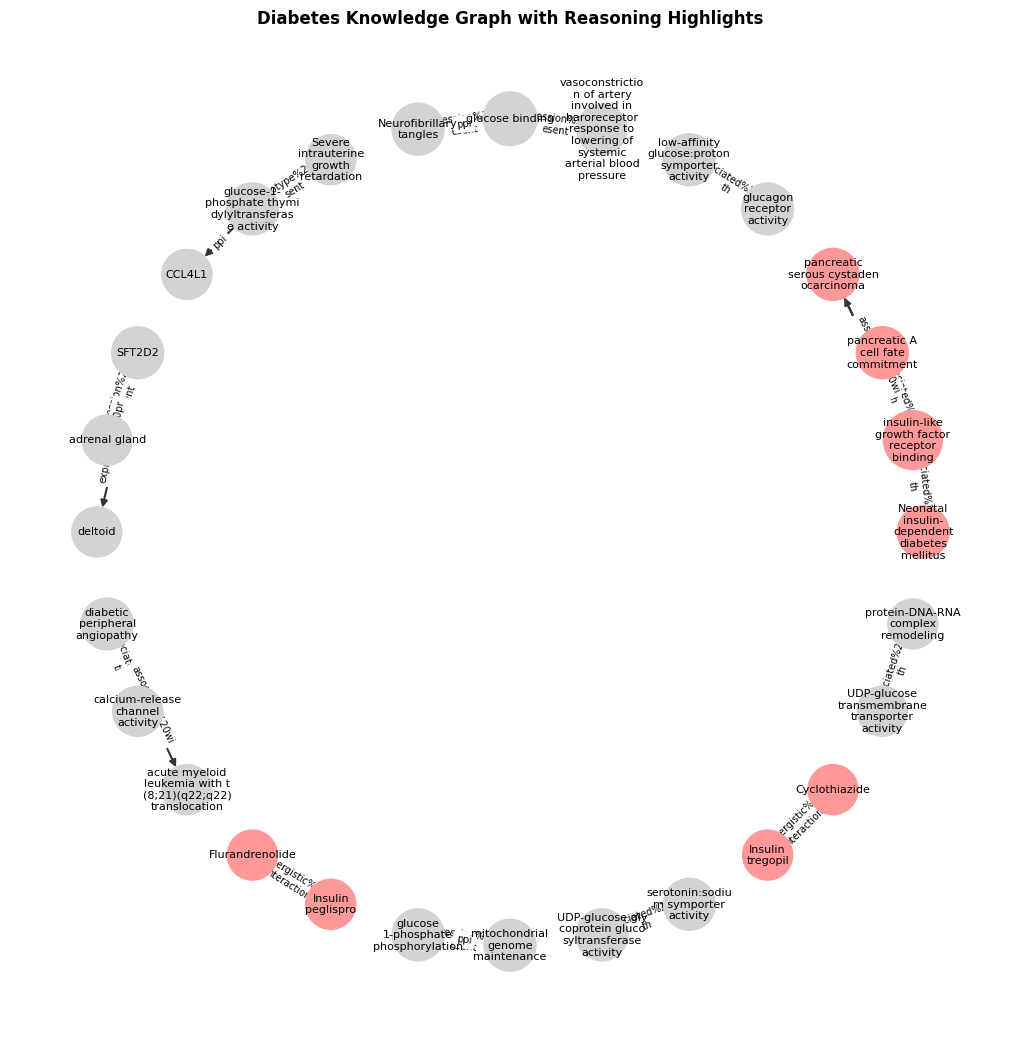


Original Answer:
1. Knowledge Triplet: Insulin resistance is a condition in which the body's cells become resistant to the effects of insulin, leading to high blood sugar levels.
2. Knowledge Triplet: The main complications of diabetes include cardiovascular disease, kidney disease, nerve damage, and eye problems.
3. Knowledge Triplet: Insulin resistance is a key factor in the development of type 2 diabetes, which can lead to these complications over time.

Answer: The main complications of diabetes, such as cardiovascular disease, kidney disease, nerve damage, and eye problems, are related to insulin resistance because insulin resistance is a key factor in the development of type 2 diabetes, which can lead to these complications over time.

--- LLM Response (Original) ---

The main complications of diabetes include cardiovascular diseases, kidney damage (nephropathy), nerve damage (neuropathy), eye damage (retinopathy), and foot damage. These complications are related to insulin resi

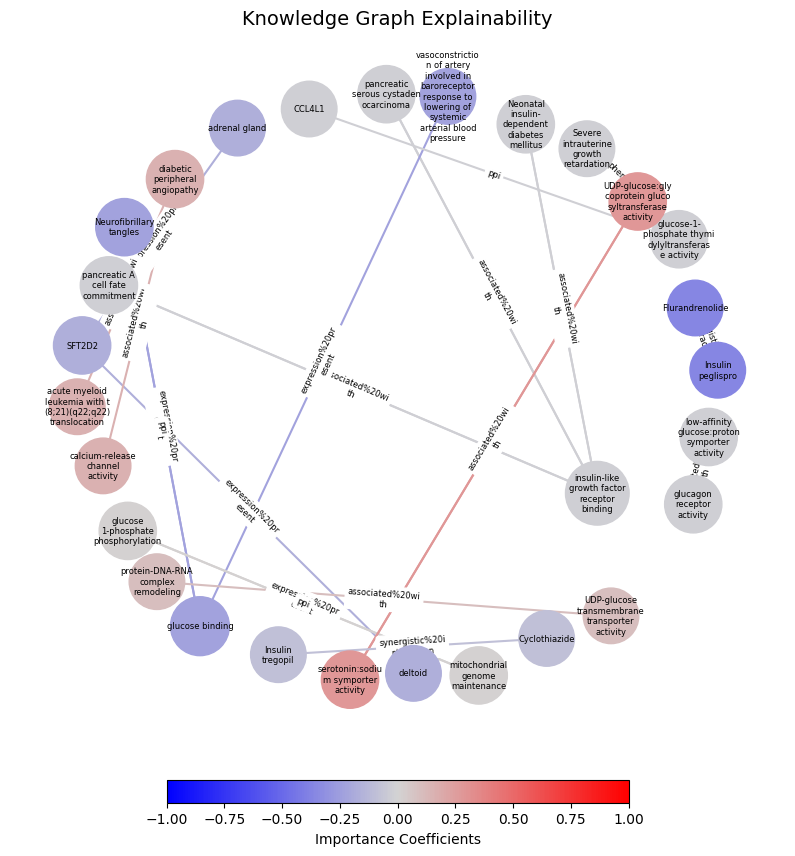

----------------------------------------------------------------------------------------------------
Fidelity:
Mean Squared Error (MSE): 0.025279965432344734
R-squared (R²): 0.6595241085738832
Mean Absolute Error (MAE): 0.12995661817296786
Mean Loss (Lm): 0.017664725777313817
Mean L1 Loss: 0.17911530692171934
Mean L2 Loss: 0.055038899475414904
Weighted L1 Loss: 0.06453811322352812
Weighted L2 Loss: 0.012554353093337977
Weighted R-squared (R²ω): 0.6595241085738832
Weighted Adjusted R-squared (Rˆ²ω): 0.2812175625448645
----------------------------------------------------------------------------------------------------
Actual vs Predicted plot saved as '/content/drive/MyDrive/PrimeKG_Data/actual_vs_predicted.png'


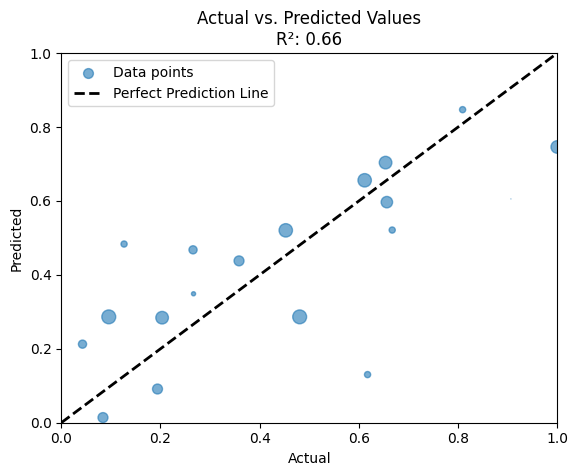

In [29]:
# Mount Google Drive
drive.mount('/content/drive')

# Initialize OpenAI client
client = OpenAI()  # Ensure OPENAI_API_KEY is set in your environment

# Path to your PrimeKG dataset and output directory
file_path = "/content/drive/MyDrive/PrimeKG_Data/final_test.json"
output_dir = "/content/drive/MyDrive/PrimeKG_Data/"

# Embedding cache and model
embedding_cache = {}
EMBEDDING_MODEL = "text-embedding-3-small"

def load_primekg_data(file_path):
    """
    Load PrimeKG data from a JSON file.

    Parameters:
    - file_path: Path to the JSON file containing PrimeKG data

    Returns:
    - List of data entries from the JSON file
    """
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        print(f"Successfully loaded {len(data)} entries from {file_path}")
        return data
    except Exception as e:
        print(f"Error loading data: {e}")
        return []

def is_diabetes_related(text):
    """
    Check if text contains diabetes-related terms.

    Parameters:
    - text: Text to check

    Returns:
    - Relevance score (0: not related, 1: secondary relation, 2: primary relation)
    """
    core_diabetes_terms = [
        'diabetes', 'diabetic', 'insulin', 'glucose',
        'type 1 diabetes', 'type 2 diabetes', 't1d', 't2d'
    ]
    secondary_terms = [
        'hyperglycemia', 'hypoglycemia', 'glycemic', 'a1c',
        'hemoglobin a1c', 'gestational diabetes', 'prediabetes',
        'metabolic syndrome', 'pancreatic', 'islet', 'beta cell',
        'metformin', 'glucagon', 'diabetic retinopathy',
        'diabetic nephropathy', 'diabetic neuropathy'
    ]

    text_lower = text.lower()
    for term in core_diabetes_terms:
        if term in text_lower:
            return 2
    for term in secondary_terms:
        if term in text_lower:
            return 1
    return 0

def extract_diabetes_knowledge_graph(data, max_parts=10):
    """
    Extract strongly connected diabetes-related knowledge graph triples from PrimeKG data.

    Parameters:
    - data: List of entries from the PrimeKG JSON file
    - max_parts: Maximum number of parts to include

    Returns:
    - kg: List of diabetes-related knowledge graph triples
    - portion_indices: Dictionary mapping portion names to ranges of triple indices
    """
    all_diabetes_triples = []
    for entry in data:
        triples = entry.get('value', [])
        if not triples:
            continue
        for triple in triples:
            if len(triple) == 3:
                subject, predicate, obj = triple
                subject_score = is_diabetes_related(subject)
                predicate_score = is_diabetes_related(predicate)
                object_score = is_diabetes_related(obj)
                total_score = subject_score + predicate_score + object_score
                if total_score > 0:
                    all_diabetes_triples.append((triple, total_score))

    all_diabetes_triples.sort(key=lambda x: x[1], reverse=True)
    G = nx.Graph()
    for (triple, _) in all_diabetes_triples:
        subject, predicate, obj = triple
        G.add_edge(subject, obj, relation=predicate)

    connected_components = list(nx.connected_components(G))
    connected_components.sort(key=len, reverse=True)
    components_to_use = connected_components[:max_parts]
    nodes_to_keep = set()
    for component in components_to_use:
        nodes_to_keep.update(component)

    filtered_triples = []
    for (triple, score) in all_diabetes_triples:
        subject, predicate, obj = triple
        if subject in nodes_to_keep and obj in nodes_to_keep:
            filtered_triples.append(triple)

    kg = []
    portion_indices = {}
    component_to_triples = defaultdict(list)
    for triple in filtered_triples:
        subject, _, obj = triple
        for i, component in enumerate(components_to_use):
            if subject in component and obj in component:
                component_to_triples[i].append(triple)
                break

    triple_index = 0
    portion_counter = 1
    print("\nStructured Diabetes Knowledge Graph (Focused on Strong Connections):\n")
    for component_idx, triples in sorted(component_to_triples.items()):
        if not triples or portion_counter > max_parts:
            continue
        triples = triples[:20]
        start_index = triple_index
        end_index = start_index + len(triples)
        portion_indices[f"Part {portion_counter}"] = range(start_index, end_index)
        print(f"\n# Part {portion_counter}")
        for triple in triples:
            subject, predicate, obj = triple
            print(f"({subject}) → ({predicate}) → ({obj})")
            kg.append((subject, predicate, obj))
            triple_index += 1
        print("-" * 80)
        portion_counter += 1
        if portion_counter > max_parts:
            break
    return kg, portion_indices

def save_knowledge_graph(kg, output_file=os.path.join(output_dir, "focused_diabetes_kg.txt")):
    """
    Save the knowledge graph to a text file in the specified Google Drive directory.

    Parameters:
    - kg: List of knowledge graph triples
    - output_file: Name of the output file (default: in output_dir)
    """
    try:
        with open(output_file, "w", encoding="utf-8") as f:
            for triple in kg:
                f.write(f"( {triple[0]} , {triple[1]} , {triple[2]} )\n\n")
        print(f"\nFocused Diabetes Knowledge Graph saved as '{output_file}'.")
    except Exception as e:
        print(f"Error saving knowledge graph to '{output_file}': {e}")

def perturb_kg_by_removing_parts(kg, parts_to_remove, portion_indices):
    """
    Perturbs the knowledge graph by removing triples from the specified parts.

    Parameters:
    - kg: List of knowledge graph triples
    - parts_to_remove: List of part names to remove
    - portion_indices: Dictionary mapping part names to triple indices

    Returns:
    - perturbed_kg: List of triples after removing specified parts
    """
    indices_to_remove = set()
    for part in parts_to_remove:
        if part in portion_indices:
            indices_to_remove.update(portion_indices[part])
    perturbed_kg = [triple for i, triple in enumerate(kg) if i not in indices_to_remove]
    return perturbed_kg

def calculate_fidelity_metrics(y_true, y_pred, weights, coeff):
    """
    Calculate and print various fidelity metrics for a regression model.
    """
    mse = mean_squared_error(y_true, y_pred, sample_weight=weights)
    r2 = r2_score(y_true, y_pred, sample_weight=weights)
    mae = mean_absolute_error(y_true, y_pred, sample_weight=weights)
    mean_loss_f = np.mean(y_true)
    mean_loss_g = np.mean(y_pred)
    mean_loss = abs(mean_loss_f - mean_loss_g)
    mean_l1 = np.mean(np.abs(y_true - y_pred))
    mean_l2 = np.mean((y_true - y_pred) ** 2)
    n = len(y_true)
    weighted_l1 = np.sum(weights * np.abs(y_true - y_pred)) / n
    weighted_l2 = np.sum(weights * (y_true - y_pred) ** 2) / n
    f_mean = np.average(y_true, weights=weights)
    ss_tot = np.sum(weights * (y_true - f_mean) ** 2)
    ss_res = np.sum(weights * (y_true - y_pred) ** 2)
    weighted_r2 = 1 - ss_res / ss_tot
    p = len(coeff)
    weighted_adj_r2 = 1 - (1 - weighted_r2) * (n - 1) / (n - p - 1)
    print(100 * '-')
    print('Fidelity:')
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"R-squared (R²): {r2}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Loss (Lm): {mean_loss}")
    print(f"Mean L1 Loss: {mean_l1}")
    print(f"Mean L2 Loss: {mean_l2}")
    print(f"Weighted L1 Loss: {weighted_l1}")
    print(f"Weighted L2 Loss: {weighted_l2}")
    print(f"Weighted R-squared (R²ω): {weighted_r2}")
    print(f"Weighted Adjusted R-squared (Rˆ²ω): {weighted_adj_r2}")
    print(100 * '-')

def normalize_text(text):
    """
    Normalize text by removing excessive spaces, normalizing Unicode characters,
    and converting to lowercase.
    """
    text = text.replace("\n", " ").strip()
    text = unicodedata.normalize("NFKC", text)
    text = re.sub(r"\s+", " ", text)
    text = text.lower()
    return text

def get_embedding(text):
    """
    Get embedding for the given text using OpenAI's API.
    """
    text = normalize_text(text)
    if text in embedding_cache:
        return embedding_cache[text]
    try:
        embedding = client.embeddings.create(input=[text], model=EMBEDDING_MODEL).data[0].embedding
        embedding_cache[text] = embedding
        return embedding
    except Exception as e:
        print(f"Error getting embedding for '{text}': {e}")
        return [0] * 1536  # Fallback embedding (dimension of text-embedding-3-small)

def get_answer_and_embedding(question, temp, graph, kg):
    """
    Sends a question to the GraphQAChain and returns the answer and its embedding.
    """
    llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=temp, openai_api_key=os.getenv("OPENAI_API_KEY"))
    chain = GraphQAChain.from_llm(llm, graph=graph, verbose=False)
    try:
        response = chain.run(question)  # Use run for older langchain versions
        original_answer_str = str(response)
    except Exception as e:
        print(f"GraphQAChain failed: {e}. Falling back to triples-based prompt.")
        triples_text = "\n".join([f"{n1} --[{r}]--> {n2}" for n1, r, n2 in kg])
        prompt = f"Knowledge graph triples:\n{triples_text}\n\nQuestion: {question}"
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "You are a helpful assistant analyzing a knowledge graph."},
                {"role": "user", "content": prompt}
            ]
        )
        original_answer_str = response.choices[0].message.content
    original_answer_embedding = get_embedding(original_answer_str)
    return original_answer_str, original_answer_embedding

def wrap_label(label, width=15):
    """
    Wraps labels to fit within a specified width for better visualization.
    """
    return '\n'.join(textwrap.wrap(label, width))

def wrap_text(text, relation, max_words=8):
    """
    Wrap text if it contains more than `max_words` words and append '_explanation' to abstract nodes.

    Parameters:
    - text: Text to wrap
    - relation: Relation type
    - max_words: Maximum number of words before wrapping

    Returns:
    - Wrapped text
    """
    if relation == "abstract":
        words = text.split()
        return f"{text}_explanation" if len(words) > max_words else text
    return text

def build_graph(kg, coeff, part_indices, cmap, norm):
    """
    Helper function to build graph, assign colors, and sizes.
    """
    G = nx.DiGraph()
    for node1, relation, node2 in kg:
        wrapped_node1 = wrap_label(wrap_text(node1, relation))
        wrapped_node2 = wrap_label(wrap_text(node2, relation))
        wrapped_relation = wrap_label(relation)
        G.add_edge(wrapped_node1, wrapped_node2, label=wrapped_relation)

    pos = nx.spring_layout(G, k=8, iterations=200, seed=0)
    node_sizes = [1500 + 100 * G.degree(node) for node in G.nodes()]

    node_colors = []
    for node in G.nodes():
        assigned_color = '#8da0cb'
        for part_name, indices in part_indices.items():
            part_idx = int(part_name.split()[-1]) - 1
            if part_idx < len(coeff):
                coeff_value = coeff[part_idx]
                color = cmap(norm(coeff_value))
                if any(i < len(kg) and (wrap_label(wrap_text(kg[i][0], kg[i][1])) == node or
                       wrap_label(wrap_text(kg[i][2], kg[i][1])) == node)
                       for i in indices):
                    assigned_color = color
                    break
        node_colors.append(assigned_color)

    edge_colors = []
    for u, v in G.edges():
        assigned_color = 'gray'
        edge_idx = None
        for i, (node1, relation, node2) in enumerate(kg):
            if (wrap_label(wrap_text(node1, relation)) == u and
                wrap_label(wrap_text(node2, relation)) == v):
                edge_idx = i
                break
        if edge_idx is not None:
            for part_name, indices in part_indices.items():
                if edge_idx in indices:
                    part_idx = int(part_name.split()[-1]) - 1
                    if part_idx < len(coeff):
                        coeff_value = coeff[part_idx]
                        color = cmap(norm(coeff_value))
                        assigned_color = color
                        break
        edge_colors.append(assigned_color)

    return G, pos, node_sizes, node_colors, edge_colors

def plot_knowledge_graph_explainability(kg, part_indices, coeff):
    """
    Improved visualization of a knowledge graph with explainability features.
    """
    cmap = mcolors.LinearSegmentedColormap.from_list('red_blue', ['blue', '#d3d3d3', 'red'])
    norm = mcolors.Normalize(vmin=-1, vmax=1)

    G, pos, node_sizes, node_colors, edge_colors = build_graph(kg, coeff, part_indices, cmap, norm)
    fig, ax = plt.subplots(figsize=(10, 10), dpi=100)

    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, ax=ax)
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=1.5, ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=6, ax=ax)
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6, ax=ax)

    ax.set_title("Knowledge Graph Explainability", fontsize=14)
    ax.axis('off')

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    fig.colorbar(sm, ax=ax, orientation='horizontal', label='Importance Coefficients', fraction=0.03, pad=0.05)

    output_file = os.path.join(output_dir, 'knowledge_graph_explainability.png')
    try:
        plt.savefig(output_file, bbox_inches='tight')
        print(f"Explainability graph saved as '{output_file}'")
    except Exception as e:
        print(f"Error saving explainability graph to '{output_file}': {e}")
    plt.show()  # Display inline in Colab
    plt.close()

def plot_actual_vs_predicted(y_true, y_pred, weights=None):
    """
    Plot actual vs. predicted values with an optional weight normalization for point sizes.
    """
    r2 = r2_score(y_true, y_pred, sample_weight=weights)
    if weights is not None:
        normalized_weights = np.array(weights) / np.max(weights) * 100
    else:
        normalized_weights = 50

    fig, ax = plt.subplots()
    ax.scatter(y_true, y_pred, s=normalized_weights, label='Data points', alpha=0.6)
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='Perfect Prediction Line')
    ax.set_xlim([min_val, max_val])
    ax.set_ylim([min_val, max_val])
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_title(f'Actual vs. Predicted Values\nR²: {r2:.2f}')
    ax.legend()

    output_file = os.path.join(output_dir, 'actual_vs_predicted.png')
    try:
        plt.savefig(output_file, bbox_inches='tight')
        print(f"Actual vs Predicted plot saved as '{output_file}'")
    except Exception as e:
        print(f"Error saving actual vs predicted plot to '{output_file}': {e}")
    plt.show()  # Display inline in Colab
    plt.close()

def extract_entities_relations(question):
    """
    Extracts entities and key relations (verbs) from the question using spaCy.
    """
    try:
        nlp = spacy.load("en_core_web_sm")
    except Exception as e:
        print(f"Error loading spaCy model: {e}. Install with: python -m spacy download en_core_web_sm")
        return [], []
    doc = nlp(question)
    entities = [ent.text for ent in doc.ents]
    # Add simple keyword matching for diabetes-related terms
    diabetes_keywords = [
        'diabetes', 'insulin', 'glucose', 'complications', 'insulin resistance',
        'diabetic', 'hyperglycemia', 'hypoglycemia', 'metformin', 'glucagon'
    ]
    for token in doc:
        if token.text.lower() in diabetes_keywords and token.text not in entities:
            entities.append(token.text)
    relations = [token.lemma_ for token in doc if token.pos_ == "VERB"]
    print(f"\nExtracted entities: {entities}")
    print(f"Extracted relations: {relations}")
    return entities, relations

def generate_chain_of_thought(kg, question):
    """
    Generates a reasoning chain by identifying relevant entities in the knowledge graph.
    """
    print("\n--- Reasoning Chain ---")
    entities, relations = extract_entities_relations(question)
    reasoning_chain = []
    relevant_nodes = set()

    for entity in entities:
        for triple in kg:
            node1, relation, node2 = triple
            if entity.lower() in node1.lower() or entity.lower() in node2.lower():
                reasoning_chain.append(triple)
                relevant_nodes.update([node1, node2])

    if not reasoning_chain:
        print("No relevant triples found for the question. Using all triples as fallback.")
        reasoning_chain = kg[:5]  # Use first 5 triples as fallback
        relevant_nodes.update([t[0] for t in reasoning_chain] + [t[2] for t in reasoning_chain])

    for step in reasoning_chain:
        print(f"{step[0]} --[{step[1]}]--> {step[2]}")

    print(f"Number of triples in reasoning chain: {len(reasoning_chain)}")
    wrapped_nodes = {wrap_label(wrap_text(node, '')) for node in relevant_nodes}
    return wrapped_nodes, reasoning_chain

def visualize_graph_circular(kg, highlighted_nodes, reasoning_chain):
    """
    Visualize the knowledge graph with a circular layout and optimized label spacing.
    """
    G = nx.DiGraph()
    for node1, relation, node2 in kg:
        wrapped_node1 = wrap_label(wrap_text(node1, relation))
        wrapped_node2 = wrap_label(wrap_text(node2, relation))
        G.add_edge(wrapped_node1, wrapped_node2, label=wrap_label(relation))

    pos = nx.circular_layout(G, scale=4)  # Increased scale for better spacing
    node_sizes = [1200 + 100 * G.degree(node) for node in G.nodes()]
    highlight_node_colors = ['#ff9999' if node in highlighted_nodes else '#d3d3d3' for node in G.nodes()]
    edge_colors = ['#333333' for _ in G.edges()]  # Darker edges for clarity

    plt.figure(figsize=(10, 10))  # Increased figure size
    nx.draw(G, pos, node_size=node_sizes, node_color=highlight_node_colors,
            edge_color=edge_colors, width=1.5, with_labels=True, arrows=True, font_size=8)
    edge_labels = {edge: G.edges[edge]['label'] for edge in G.edges()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7, label_pos=0.5)

    plt.title("Diabetes Knowledge Graph with Reasoning Highlights", fontsize=12, fontweight='bold')
    output_file = os.path.join(output_dir, 'knowledge_graph_circular_optimized.png')
    try:
        plt.savefig(output_file, bbox_inches='tight', dpi=150)
        print(f"\nCircular graph saved as '{output_file}'")
    except Exception as e:
        print(f"Error saving circular graph to '{output_file}': {e}")
    plt.show()  # Display the plot inline in Colab

def format_triples_for_prompt(reasoning_chain, question):
    """
    Formats the extracted triples into a readable structure for LLM input.

    Parameters:
    - reasoning_chain: List of triples (node1, relation, node2)
    - question: The question to append to the prompt

    Returns:
    - Formatted prompt string
    """
    if not reasoning_chain:
        return "No relevant triples extracted from the knowledge graph.\n\nQuestion: " + question

    prompt = "The following triples represent relevant knowledge about the question:\n\n"
    for triple in reasoning_chain:
        if isinstance(triple, (list, tuple)) and len(triple) == 3:
            prompt += f"- {triple[0]} --[{triple[1]}]--> {triple[2]}\n"

    prompt += "\nBased on the above information, answer the question:\n"
    prompt += question
    return prompt

def get_chat_response(prompt):
    """
    Get a response from the OpenAI Chat API.
    """
    try:
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "You are a helpful assistant analyzing a knowledge graph."},
                {"role": "user", "content": prompt}
            ]
        )
        return response.choices[0].message.content
    except Exception as e:
        print(f"Error in get_chat_response: {e}")
        return "Unable to generate response."

def main():
    # Load data from PrimeKG JSON file
    primekg_data = load_primekg_data(file_path)

    if not primekg_data:
        print("No data loaded. Please check the file path.")
        return

    # Extract diabetes-related knowledge graph
    kg, portion_indices = extract_diabetes_knowledge_graph(primekg_data, max_parts=10)

    if not kg:
        print("No diabetes-related information found in the dataset.")
        return

    print(f"\nFound {len(kg)} strongly connected diabetes-related triples in the dataset.")
    print(f"Organized into {len(portion_indices)} parts.")

    # Print portion indices
    print("\nPortion Indices:\n")
    for part, index_range in portion_indices.items():
        print(f"{part}: {index_range}")

    # Save knowledge graph
    save_knowledge_graph(kg)

    # Print the final KG
    print("\nFinal Focused Diabetes Knowledge Graph List:\n")
    for triple in kg:
        print("(", triple[0], ",", triple[1], ", ", triple[2], ")")

    # Instantiate the graph for LangChain
    graph = NetworkxEntityGraph()

    # Build the graph using GraphDocument
    nodes = {}
    relationships = []
    # Create a source Document with page_content summarizing the triples
    triples_text = "\n".join([f"{n1} --[{r}]--> {n2}" for n1, r, n2 in kg])
    source_doc = Document(page_content=triples_text, metadata={"source": "PrimeKG"})

    for node1, relation, node2 in kg:
        if node1 not in nodes:
            nodes[node1] = Node(id=node1, type="Entity")
        if node2 not in nodes:
            nodes[node2] = Node(id=node2, type="Entity")
        relationships.append(Relationship(source=nodes[node1], target=nodes[node2], type=relation))

    graph_doc = GraphDocument(nodes=list(nodes.values()), relationships=relationships, source=source_doc)
    for node in graph_doc.nodes:
        graph.add_node(node.id)
    for rel in graph_doc.relationships:
        triple = KnowledgeTriple(subject=rel.source.id, predicate=rel.type, object_=rel.target.id)
        graph.add_triple(triple)

    # Define a sample question
    question = "What are the main complications of diabetes and how are they related to insulin resistance?"

    # Define the original vector for perturbation experiments
    part_names = list(portion_indices.keys())
    original = np.ones(len(part_names))
    original = original.reshape(1, -1)

    # Generate chain of thought reasoning
    highlighted_nodes, reasoning_chain = generate_chain_of_thought(kg, question)

    # Visualize the graph with reasoning highlights
    visualize_graph_circular(kg, highlighted_nodes, reasoning_chain)

    # Get original answer and embedding
    temp = 0
    original_answer_str, original_answer_embedding = get_answer_and_embedding(question, temp, graph, kg)
    print("\nOriginal Answer:")
    print(original_answer_str)

    # Format the extracted triples for the original prompt
    structured_prompt = format_triples_for_prompt(reasoning_chain, question)

    # Get response from LLM (original answer)
    original_answer = get_chat_response(structured_prompt)
    print("\n--- LLM Response (Original) ---\n")
    print(original_answer)

    # Perturbation analysis
    similarities_cosine = []
    similarities_wd = []
    generated_embeddings = []
    perturbations_vect2 = []
    perturbation_texts = []

    # Loop for perturbations
    for i in range(20):
        perturbation_vector = original.copy().flatten()

        # Randomly choose parts to remove
        num_parts_to_remove = random.randint(1, len(part_names))
        parts_to_remove_indices = random.sample(range(len(part_names)), num_parts_to_remove)

        # Set selected parts to 0
        for part_idx in parts_to_remove_indices:
            perturbation_vector[part_idx] = 0

        perturbations_vect2.append(perturbation_vector)

        # Perturb the KG
        parts_to_remove = [part_names[idx] for idx in parts_to_remove_indices]
        perturbed_kg = perturb_kg_by_removing_parts(kg, parts_to_remove, portion_indices)

        # Generate extracted triples from perturbed KG
        _, perturbed_reasoning_chain = generate_chain_of_thought(perturbed_kg, question)

        if not perturbed_reasoning_chain:
            perturbed_reasoning_chain = []  # Ensure it's an empty list to avoid errors

        # Format extracted triples for LLM input
        structured_prompt = format_triples_for_prompt(perturbed_reasoning_chain, question)

        # Get response from LLM
        temp_response = get_chat_response(structured_prompt)

        # Handle None or empty response
        if not temp_response or temp_response.strip() == "":
            temp_response = "No meaningful response generated."
        perturbation_texts.append(temp_response)

        # Get embedding for the perturbed response
        try:
            temp_response_embedding = get_embedding(temp_response)
            generated_embeddings.append(temp_response_embedding)
        except Exception as e:
            print(f"Error generating embedding for response: {temp_response}")
            print(f"Exception: {e}")
            continue

        # Calculate Wasserstein distance between the original and perturbed responses
        similarity_wd = wasserstein_distance(original_answer_embedding, temp_response_embedding)
        similarities_wd.append(similarity_wd)

        # Calculate cosine similarity between the original and perturbed responses
        similarity_cosine = 1 - cosine_distances([original_answer_embedding], [temp_response_embedding])[0][0]
        similarities_cosine.append(similarity_cosine)

        print(f"\nIteration {i + 1}")
        print(f"Parts removed: {parts_to_remove}")
        print(f"Original answer: {original_answer_str}")
        print(f"Perturbed response: {temp_response}")
        print(f"Wasserstein Distance with original answer: {similarity_wd}")
        print(f"Cosine Similarity with original answer: {similarity_cosine}\n")

    # Convert perturbations_vect2 to a numpy array for pairwise distance calculation
    perturbations_vect2 = np.array(perturbations_vect2)

    # Calculate cosine distances between perturbation vectors and the original vector
    distances = cosine_distances(perturbations_vect2, original).ravel()

    # Compute weights using kernel width
    kernel_width = 0.25
    weights = np.sqrt(np.exp(-(distances**2)/(kernel_width**2)))

    # Print all similarities and weights
    print("\n--- Perturbation Analysis Summary ---")
    print(f"Wasserstein Distances: {similarities_wd}")
    print(f"Cosine Similarities: {similarities_cosine}")
    print(f"Weights: {weights.tolist()}")

    # Print all perturbation texts for a consolidated view
    print("\n--- Summary of Perturbations ---")
    for i, text in enumerate(perturbation_texts):
        print(f"Perturbation {i + 1}: {text}")

    # Additional analysis: Inverse Wasserstein distances and regression
    epsilon = 1e-6
    inverse_similarities_wd = [1.0 / (dist + epsilon) for dist in similarities_wd]

    # Find min and max of inverse Wasserstein distances
    min_value = min(inverse_similarities_wd)
    max_value = max(inverse_similarities_wd)

    # Scale inverse Wasserstein distances between 0 and 1
    Similarities_ = [(value - min_value) / (max_value - min_value) for value in inverse_similarities_wd]
    print("\nScaled Inverse Wasserstein Similarities:")
    print(Similarities_)

    # Train linear regression model
    simpler_model = LinearRegression()
    simpler_model.fit(X=perturbations_vect2, y=Similarities_, sample_weight=weights)
    coeff = simpler_model.coef_
    print("\nLinear Regression Coefficients:")
    print(coeff)

    # Plot knowledge graph explainability
    plot_knowledge_graph_explainability(kg, portion_indices, coeff)

    # Compute y_true and y_pred
    y_true = np.array(Similarities_).ravel()
    y_pred = simpler_model.predict(perturbations_vect2).ravel()

    # Calculate fidelity metrics
    calculate_fidelity_metrics(y_true, y_pred, weights, coeff)

    # Plot actual vs predicted
    plot_actual_vs_predicted(y_true, y_pred, weights)

if __name__ == "__main__":
    main()

# Preprompt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Successfully loaded 17074 entries from /content/drive/MyDrive/PrimeKG_Data/final_test.json

Structured Diabetes Knowledge Graph (Focused on Strong Connections):


# Part 1
(Neonatal insulin-dependent diabetes mellitus) → (associated%20with) → (insulin-like growth factor receptor binding)
(insulin-like growth factor receptor binding) → (ppi) → (Neonatal insulin-dependent diabetes mellitus)
(Neonatal insulin-dependent diabetes mellitus) → (associated%20with) → (insulin-like growth factor receptor binding)
(insulin-like growth factor receptor binding) → (ppi) → (Neonatal insulin-dependent diabetes mellitus)
(Neonatal insulin-dependent diabetes mellitus) → (ppi) → (insulin-like growth factor receptor binding)
(insulin-like growth factor receptor binding) → (associated%20with) → (Neonatal insulin-dependent diabetes mellitus)
(Neonatal insulin-dependent diabetes me

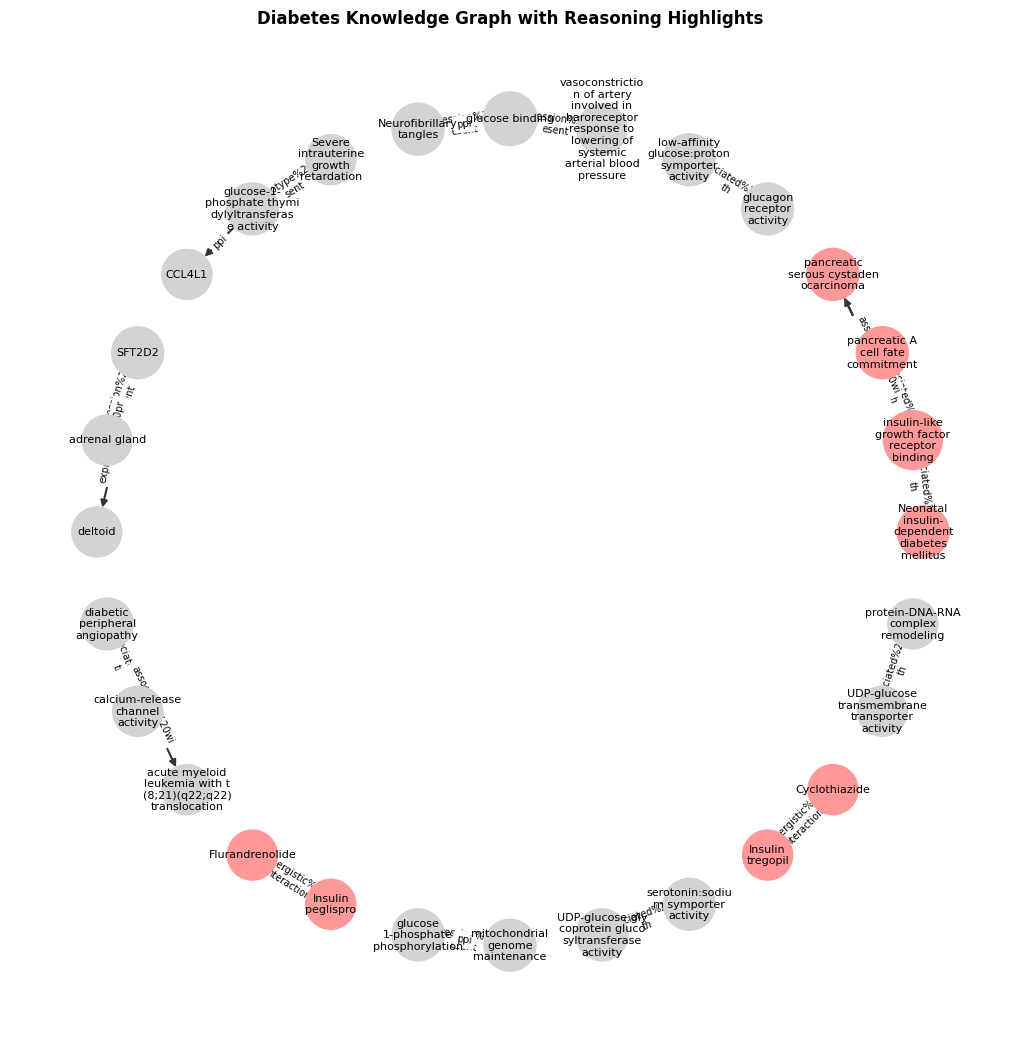


Iteration 1
Parts removed: ['Part 8', 'Part 9']
Original response: Insulin resistance is a condition where the body's cells do not respond properly to insulin, leading to high blood sugar levels. The main complications of diabetes, such as cardiovascular disease, kidney disease, and nerve damage, are connected to insulin resistance because the inability of cells to respond to insulin properly results in elevated blood sugar levels, which can damage blood vessels and organs over time. This damage can lead to the development of complications associated with diabetes.
Perturbed response: Insulin resistance is a condition where the body's cells do not respond properly to insulin, leading to high blood sugar levels. The main complications of diabetes, such as cardiovascular disease, kidney disease, and nerve damage, are connected to insulin resistance because the inability of cells to respond to insulin properly results in elevated blood sugar levels, which can damage blood vessels and org

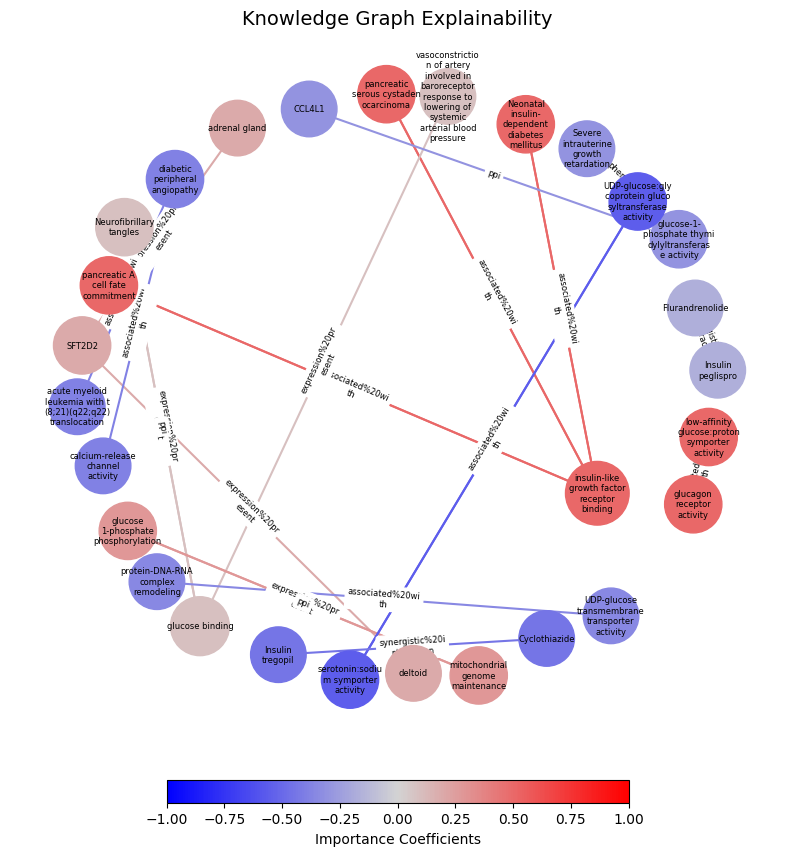

----------------------------------------------------------------------------------------------------
Fidelity:
Mean Squared Error (MSE): 0.034506798882780354
R-squared (R²): 0.8496860374128853
Mean Absolute Error (MAE): 0.14321619113524103
Mean Loss (Lm): 0.1601779204015389
Mean L1 Loss: 0.2990669774664123
Mean L2 Loss: 0.17659646208022906
Weighted L1 Loss: 0.06524313670971234
Weighted L2 Loss: 0.015719813374996294
Weighted R-squared (R²ω): 0.8496860374128853
Weighted Adjusted R-squared (Rˆ²ω): 0.6826705234272022
----------------------------------------------------------------------------------------------------
Actual vs Predicted plot saved as '/content/drive/MyDrive/PrimeKG_Data/actual_vs_predicted.png'


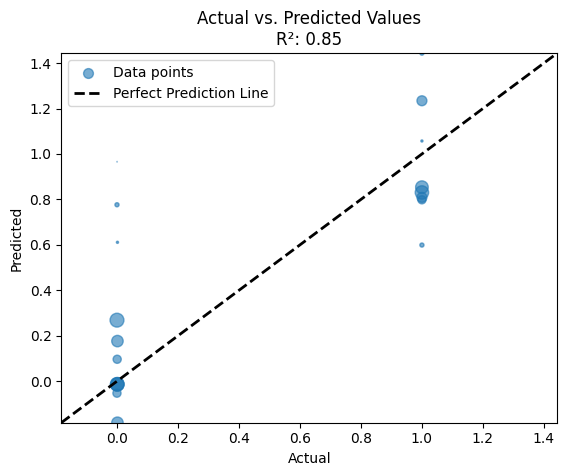

In [31]:
`# Mount Google Drive
drive.mount('/content/drive')

# Initialize logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Initialize OpenAI client
client = OpenAI()  # Ensure OPENAI_API_KEY is set

# Path to your PrimeKG dataset and output directory
file_path = "/content/drive/MyDrive/PrimeKG_Data/final_test.json"
output_dir = "/content/drive/MyDrive/PrimeKG_Data/"

# Embedding cache and model
embedding_cache = {}
EMBEDDING_MODEL = "text-embedding-3-small"
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

def load_primekg_data(file_path):
    """
    Load PrimeKG data from a JSON file.
    """
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        print(f"Successfully loaded {len(data)} entries from {file_path}")
        return data
    except Exception as e:
        print(f"Error loading data: {e}")
        return []

def is_diabetes_related(text):
    """
    Check if text contains diabetes-related terms.
    """
    core_diabetes_terms = [
        'diabetes', 'diabetic', 'insulin', 'glucose',
        'type 1 diabetes', 'type 2 diabetes', 't1d', 't2d'
    ]
    secondary_terms = [
        'hyperglycemia', 'hypoglycemia', 'glycemic', 'a1c',
        'hemoglobin a1c', 'gestational diabetes', 'prediabetes',
        'metabolic syndrome', 'pancreatic', 'islet', 'beta cell',
        'metformin', 'glucagon', 'diabetic retinopathy',
        'diabetic nephropathy', 'diabetic neuropathy'
    ]
    text_lower = text.lower()
    for term in core_diabetes_terms:
        if term in text_lower:
            return 2
    for term in secondary_terms:
        if term in text_lower:
            return 1
    return 0

def extract_diabetes_knowledge_graph(data, max_parts=10):
    """
    Extract strongly connected diabetes-related knowledge graph triples.
    """
    all_diabetes_triples = []
    for entry in data:
        triples = entry.get('value', [])
        if not triples:
            continue
        for triple in triples:
            if len(triple) == 3:
                subject, predicate, obj = triple
                subject_score = is_diabetes_related(subject)
                predicate_score = is_diabetes_related(predicate)
                object_score = is_diabetes_related(obj)
                total_score = subject_score + predicate_score + object_score
                if total_score > 0:
                    all_diabetes_triples.append((triple, total_score))

    all_diabetes_triples.sort(key=lambda x: x[1], reverse=True)
    G = nx.Graph()
    for (triple, _) in all_diabetes_triples:
        subject, predicate, obj = triple
        G.add_edge(subject, obj, relation=predicate)

    connected_components = list(nx.connected_components(G))
    connected_components.sort(key=len, reverse=True)
    components_to_use = connected_components[:max_parts]
    nodes_to_keep = set()
    for component in components_to_use:
        nodes_to_keep.update(component)

    filtered_triples = []
    for (triple, score) in all_diabetes_triples:
        subject, predicate, obj = triple
        if subject in nodes_to_keep and obj in nodes_to_keep:
            filtered_triples.append(triple)

    kg = []
    portion_indices = {}
    component_to_triples = defaultdict(list)
    for triple in filtered_triples:
        subject, _, obj = triple
        for i, component in enumerate(components_to_use):
            if subject in component and obj in component:
                component_to_triples[i].append(triple)
                break

    triple_index = 0
    portion_counter = 1
    print("\nStructured Diabetes Knowledge Graph (Focused on Strong Connections):\n")
    for component_idx, triples in sorted(component_to_triples.items()):
        if not triples or portion_counter > max_parts:
            continue
        triples = triples[:20]
        start_index = triple_index
        end_index = start_index + len(triples)
        portion_indices[f"Part {portion_counter}"] = range(start_index, end_index)
        print(f"\n# Part {portion_counter}")
        for triple in triples:
            subject, predicate, obj = triple
            print(f"({subject}) → ({predicate}) → ({obj})")
            kg.append((subject, predicate, obj))
            triple_index += 1
        print("-" * 80)
        portion_counter += 1
        if portion_counter > max_parts:
            break
    return kg, portion_indices

def save_knowledge_graph(kg, output_file=os.path.join(output_dir, "focused_diabetes_kg.txt")):
    """
    Save the knowledge graph to a text file.
    """
    try:
        with open(output_file, "w", encoding="utf-8") as f:
            for triple in kg:
                f.write(f"( {triple[0]} , {triple[1]} , {triple[2]} )\n\n")
        print(f"\nFocused Diabetes Knowledge Graph saved as '{output_file}'.")
    except Exception as e:
        print(f"Error saving knowledge graph to '{output_file}': {e}")

def perturb_kg_by_removing_parts(kg, parts_to_remove, portion_indices):
    """
    Perturbs the knowledge graph by removing triples from specified parts.
    """
    indices_to_remove = set()
    for part in parts_to_remove:
        if part in portion_indices:
            indices_to_remove.update(portion_indices[part])
    perturbed_kg = [triple for i, triple in enumerate(kg) if i not in indices_to_remove]
    return perturbed_kg

def calculate_fidelity_metrics(y_true, y_pred, weights, coeff):
    """
    Calculate and print fidelity metrics for a regression model.
    """
    mse = mean_squared_error(y_true, y_pred, sample_weight=weights)
    r2 = r2_score(y_true, y_pred, sample_weight=weights)
    mae = mean_absolute_error(y_true, y_pred, sample_weight=weights)
    mean_loss_f = np.mean(y_true)
    mean_loss_g = np.mean(y_pred)
    mean_loss = abs(mean_loss_f - mean_loss_g)
    mean_l1 = np.mean(np.abs(y_true - y_pred))
    mean_l2 = np.mean((y_true - y_pred) ** 2)
    n = len(y_true)
    weighted_l1 = np.sum(weights * np.abs(y_true - y_pred)) / n
    weighted_l2 = np.sum(weights * (y_true - y_pred) ** 2) / n
    f_mean = np.average(y_true, weights=weights)
    ss_tot = np.sum(weights * (y_true - f_mean) ** 2)
    ss_res = np.sum(weights * (y_true - y_pred) ** 2)
    weighted_r2 = 1 - ss_res / ss_tot
    p = len(coeff)
    weighted_adj_r2 = 1 - (1 - weighted_r2) * (n - 1) / (n - p - 1)
    print(100 * '-')
    print('Fidelity:')
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"R-squared (R²): {r2}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Loss (Lm): {mean_loss}")
    print(f"Mean L1 Loss: {mean_l1}")
    print(f"Mean L2 Loss: {mean_l2}")
    print(f"Weighted L1 Loss: {weighted_l1}")
    print(f"Weighted L2 Loss: {weighted_l2}")
    print(f"Weighted R-squared (R²ω): {weighted_r2}")
    print(f"Weighted Adjusted R-squared (Rˆ²ω): {weighted_adj_r2}")
    print(100 * '-')

def normalize_text(text):
    """
    Normalize text for embedding.
    """
    text = text.replace("\n", " ").strip()
    text = unicodedata.normalize("NFKC", text)
    text = re.sub(r"\s+", " ", text)
    text = text.lower()
    return text

def get_embedding(text):
    """
    Get embedding using OpenAI's API.
    """
    text = normalize_text(text)
    if text in embedding_cache:
        return embedding_cache[text]
    try:
        embedding = client.embeddings.create(input=[text], model=EMBEDDING_MODEL).data[0].embedding
        embedding_cache[text] = embedding
        return embedding
    except Exception as e:
        print(f"Error getting embedding for '{text}': {e}")
        return [0] * 1536  # Fallback embedding

def get_answer_and_embedding(question, temp, graph, kg):
    """
    Sends a question to GraphQAChain and returns answer and embedding.
    """
    llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=temp, openai_api_key=os.getenv("OPENAI_API_KEY"))
    chain = GraphQAChain.from_llm(llm, graph=graph, verbose=False)
    try:
        response = chain.run(question)
        answer_str = str(response)
    except Exception as e:
        print(f"GraphQAChain failed: {e}. Falling back to triples-based prompt.")
        triples_text = "\n".join([f"{n1} --[{r}]--> {n2}" for n1, r, n2 in kg])
        prompt = f"Knowledge graph triples:\n{triples_text}\n\nQuestion: {question}"
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "You are a helpful assistant analyzing a knowledge graph."},
                {"role": "user", "content": prompt}
            ]
        )
        answer_str = response.choices[0].message.content
    answer_embedding = get_embedding(answer_str)
    return answer_str, answer_embedding

def wrap_label(label, width=15):
    """
    Wraps labels for visualization.
    """
    return '\n'.join(textwrap.wrap(label, width))

def wrap_text(text, relation, max_words=8):
    """
    Wrap text for visualization.
    """
    if relation == "abstract":
        words = text.split()
        return f"{text}_explanation" if len(words) > max_words else text
    return text

def build_graph(kg, coeff, part_indices, cmap, norm):
    """
    Build graph for explainability visualization.
    """
    G = nx.DiGraph()
    for node1, relation, node2 in kg:
        wrapped_node1 = wrap_label(wrap_text(node1, relation))
        wrapped_node2 = wrap_label(wrap_text(node2, relation))
        wrapped_relation = wrap_label(relation)
        G.add_edge(wrapped_node1, wrapped_node2, label=wrapped_relation)

    pos = nx.spring_layout(G, k=8, iterations=200, seed=0)
    node_sizes = [1500 + 100 * G.degree(node) for node in G.nodes()]

    node_colors = []
    for node in G.nodes():
        assigned_color = '#8da0cb'
        for part_name, indices in part_indices.items():
            part_idx = int(part_name.split()[-1]) - 1
            if part_idx < len(coeff):
                coeff_value = coeff[part_idx]
                color = cmap(norm(coeff_value))
                if any(i < len(kg) and (wrap_label(wrap_text(kg[i][0], kg[i][1])) == node or
                       wrap_label(wrap_text(kg[i][2], kg[i][1])) == node)
                       for i in indices):
                    assigned_color = color
                    break
        node_colors.append(assigned_color)

    edge_colors = []
    for u, v in G.edges():
        assigned_color = 'gray'
        edge_idx = None
        for i, (node1, relation, node2) in enumerate(kg):
            if (wrap_label(wrap_text(node1, relation)) == u and
                wrap_label(wrap_text(node2, relation)) == v):
                edge_idx = i
                break
        if edge_idx is not None:
            for part_name, indices in part_indices.items():
                if edge_idx in indices:
                    part_idx = int(part_name.split()[-1]) - 1
                    if part_idx < len(coeff):
                        coeff_value = coeff[part_idx]
                        color = cmap(norm(coeff_value))
                        assigned_color = color
                        break
        edge_colors.append(assigned_color)

    return G, pos, node_sizes, node_colors, edge_colors

def plot_knowledge_graph_explainability(kg, part_indices, coeff):
    """
    Visualize knowledge graph with explainability features.
    """
    cmap = mcolors.LinearSegmentedColormap.from_list('red_blue', ['blue', '#d3d3d3', 'red'])
    norm = mcolors.Normalize(vmin=-1, vmax=1)

    G, pos, node_sizes, node_colors, edge_colors = build_graph(kg, coeff, part_indices, cmap, norm)
    fig, ax = plt.subplots(figsize=(10, 10), dpi=100)

    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, ax=ax)
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=1.5, ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=6, ax=ax)
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6, ax=ax)

    ax.set_title("Knowledge Graph Explainability", fontsize=14)
    ax.axis('off')

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    fig.colorbar(sm, ax=ax, orientation='horizontal', label='Importance Coefficients', fraction=0.03, pad=0.05)

    output_file = os.path.join(output_dir, 'knowledge_graph_explainability.png')
    try:
        plt.savefig(output_file, bbox_inches='tight')
        print(f"Explainability graph saved as '{output_file}'")
    except Exception as e:
        print(f"Error saving explainability graph to '{output_file}': {e}")
    plt.show()
    plt.close()

def plot_actual_vs_predicted(y_true, y_pred, weights=None):
    """
    Plot actual vs. predicted values.
    """
    r2 = r2_score(y_true, y_pred, sample_weight=weights)
    if weights is not None:
        normalized_weights = np.array(weights) / np.max(weights) * 100
    else:
        normalized_weights = 50

    fig, ax = plt.subplots()
    ax.scatter(y_true, y_pred, s=normalized_weights, label='Data points', alpha=0.6)
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='Perfect Prediction Line')
    ax.set_xlim([min_val, max_val])
    ax.set_ylim([min_val, max_val])
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_title(f'Actual vs. Predicted Values\nR²: {r2:.2f}')
    ax.legend()

    output_file = os.path.join(output_dir, 'actual_vs_predicted.png')
    try:
        plt.savefig(output_file, bbox_inches='tight')
        print(f"Actual vs Predicted plot saved as '{output_file}'")
    except Exception as e:
        print(f"Error saving actual vs predicted plot to '{output_file}': {e}")
    plt.show()
    plt.close()

def extract_entities_relations(question):
    """
    Extracts entities and relations from the question using spaCy.
    """
    try:
        nlp = spacy.load("en_core_web_sm")
    except Exception as e:
        print(f"Error loading spaCy model: {e}. Install with: python -m spacy download en_core_web_sm")
        return [], []
    doc = nlp(question)
    entities = [ent.text for ent in doc.ents]
    diabetes_keywords = [
        'diabetes', 'insulin', 'glucose', 'complications', 'insulin resistance',
        'diabetic', 'hyperglycemia', 'hypoglycemia', 'metformin', 'glucagon'
    ]
    for token in doc:
        if token.text.lower() in diabetes_keywords and token.text not in entities:
            entities.append(token.text)
    relations = [token.lemma_ for token in doc if token.pos_ == "VERB"]
    print(f"\nExtracted entities: {entities}")
    print(f"Extracted relations: {relations}")
    return entities, relations

def generate_chain_of_thought(kg, question):
    """
    Generates a reasoning chain from the knowledge graph.
    """
    print("\n--- Reasoning Chain ---")
    entities, relations = extract_entities_relations(question)
    reasoning_chain = []
    relevant_nodes = set()

    for entity in entities:
        for triple in kg:
            node1, relation, node2 = triple
            if entity.lower() in node1.lower() or entity.lower() in node2.lower():
                reasoning_chain.append(triple)
                relevant_nodes.update([node1, node2])

    if not reasoning_chain:
        print("No relevant triples found. Using all triples as fallback.")
        reasoning_chain = kg[:5]
        relevant_nodes.update([t[0] for t in reasoning_chain] + [t[2] for t in reasoning_chain])

    for step in reasoning_chain:
        print(f"{step[0]} --[{step[1]}]--> {step[2]}")

    print(f"Number of triples in reasoning chain: {len(reasoning_chain)}")
    wrapped_nodes = {wrap_label(wrap_text(node, '')) for node in relevant_nodes}
    return wrapped_nodes, reasoning_chain

def visualize_graph_circular(kg, highlighted_nodes, reasoning_chain):
    """
    Visualize knowledge graph with circular layout.
    """
    G = nx.DiGraph()
    for node1, relation, node2 in kg:
        wrapped_node1 = wrap_label(wrap_text(node1, relation))
        wrapped_node2 = wrap_label(wrap_text(node2, relation))
        G.add_edge(wrapped_node1, wrapped_node2, label=wrap_label(relation))

    pos = nx.circular_layout(G, scale=4)
    node_sizes = [1200 + 100 * G.degree(node) for node in G.nodes()]
    highlight_node_colors = ['#ff9999' if node in highlighted_nodes else '#d3d3d3' for node in G.nodes()]
    edge_colors = ['#333333' for _ in G.edges()]

    plt.figure(figsize=(10, 10))
    nx.draw(G, pos, node_size=node_sizes, node_color=highlight_node_colors,
            edge_color=edge_colors, width=1.5, with_labels=True, arrows=True, font_size=8)
    edge_labels = {edge: G.edges[edge]['label'] for edge in G.edges()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7, label_pos=0.5)

    plt.title("Diabetes Knowledge Graph with Reasoning Highlights", fontsize=12, fontweight='bold')
    output_file = os.path.join(output_dir, 'knowledge_graph_circular_optimized.png')
    try:
        plt.savefig(output_file, bbox_inches='tight', dpi=150)
        print(f"\nCircular graph saved as '{output_file}'")
    except Exception as e:
        print(f"Error saving circular graph to '{output_file}': {e}")
    plt.show()

def rephrase_question_via_openai(question, num_variants=5):
    """
    Create rephrased versions of the input question.
    """
    text = f"Please rephrase the following question in {num_variants} different ways:\nQuestion: {question}"
    try:
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[{"role": "user", "content": text}]
        )
        response_text = response.choices[0].message.content
        rephrased_questions = [q.strip() for q in response_text.split("\n") if q.strip()]
        return rephrased_questions[:num_variants]
    except Exception as e:
        logging.error(f"Error rephrasing question: {e}")
        return [question] * num_variants

def run_questions_with_graph_qa(questions, graph, kg):
    """
    Run questions through GraphQAChain and collect answers.
    """
    results = {}
    llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0, openai_api_key=os.getenv("OPENAI_API_KEY"))
    chain = GraphQAChain.from_llm(llm, graph=graph, verbose=False)
    for question in questions:
        try:
            answer = chain.run(question)
            results[question] = answer
        except Exception as e:
            logging.error(f"Error running question '{question}': {e}")
            triples_text = "\n".join([f"{n1} --[{r}]--> {n2}" for n1, r, n2 in kg])
            prompt = f"Knowledge graph triples:\n{triples_text}\n\nQuestion: {question}"
            response = client.chat.completions.create(
                model="gpt-3.5-turbo",
                messages=[
                    {"role": "system", "content": "You are a helpful assistant analyzing a knowledge graph."},
                    {"role": "user", "content": prompt}
                ]
            )
            results[question] = response.choices[0].message.content
    return results

def filter_valid_answers(answers):
    """
    Remove invalid answers.
    """
    valid_answers = {q: ans for q, ans in answers.items() if "I do not know" not in ans and "I don't know" not in ans}
    return valid_answers

def aggregate_answers_with_embeddings(valid_answers):
    """
    Aggregate answers using cosine similarity of embeddings.
    """
    if not valid_answers:
        return "No valid answers available."
    answer_list = list(valid_answers.values())
    embeddings = embedding_model.encode(answer_list)
    centroid = np.mean(embeddings, axis=0).reshape(1, -1)
    similarities_to_centroid = cosine_similarity(embeddings, centroid).flatten()
    best_index = np.argmax(similarities_to_centroid)
    return answer_list[best_index]

def main():
    # Load data
    primekg_data = load_primekg_data(file_path)
    if not primekg_data:
        print("No data loaded.")
        return

    # Extract knowledge graph
    kg, portion_indices = extract_diabetes_knowledge_graph(primekg_data, max_parts=10)
    if not kg:
        print("No diabetes-related information found.")
        return

    print(f"\nFound {len(kg)} triples in {len(portion_indices)} parts.")
    print("\nPortion Indices:\n")
    for part, index_range in portion_indices.items():
        print(f"{part}: {index_range}")

    # Save knowledge graph
    save_knowledge_graph(kg)

    # Print final KG
    print("\nFinal Focused Diabetes Knowledge Graph List:\n")
    for triple in kg:
        print("(", triple[0], ",", triple[1], ", ", triple[2], ")")

    # Build graph for LangChain
    graph = NetworkxEntityGraph()
    nodes = {}
    relationships = []
    triples_text = "\n".join([f"{n1} --[{r}]--> {n2}" for n1, r, n2 in kg])
    source_doc = Document(page_content=triples_text, metadata={"source": "PrimeKG"})

    for node1, relation, node2 in kg:
        if node1 not in nodes:
            nodes[node1] = Node(id=node1, type="Entity")
        if node2 not in nodes:
            nodes[node2] = Node(id=node2, type="Entity")
        relationships.append(Relationship(source=nodes[node1], target=nodes[node2], type=relation))

    graph_doc = GraphDocument(nodes=list(nodes.values()), relationships=relationships, source=source_doc)
    for node in graph_doc.nodes:
        graph.add_node(node.id)
    for rel in graph_doc.relationships:
        triple = KnowledgeTriple(subject=rel.source.id, predicate=rel.type, object_=rel.target.id)
        graph.add_triple(triple)

    # Define question
    question = "What are the main complications of diabetes and how are they related to insulin resistance?"

    # Preprompt: Generate and aggregate rephrased questions
    rephrased_questions = rephrase_question_via_openai(question)
    answers = run_questions_with_graph_qa(rephrased_questions, graph, kg)
    filtered_answers = filter_valid_answers(answers)

    if not filtered_answers:
        original_answer = "No valid answers available."
    else:
        original_answer = aggregate_answers_with_embeddings(filtered_answers)

    # Save and print answers
    output_file = os.path.join(output_dir, "final_answer.txt")
    try:
        with open(output_file, "w", encoding="utf-8") as file:
            file.write(original_answer)
        print(f"\nFinal answer saved as '{output_file}'")
    except Exception as e:
        print(f"Error saving final answer to '{output_file}': {e}")

    print("\nRephrased Questions and Their Answers:\n" + "="*50)
    for q, a in answers.items():
        print(f"Question: {q}\nAnswer: {a}\n{'-'*50}")
    print("\nFiltered Questions and Their Answers:\n" + "="*50)
    for q, a in filtered_answers.items():
        print(f"Question: {q}\nAnswer: {a}\n{'-'*50}")
    print("\nFinal Aggregated Answer:\n" + "="*50)
    print(original_answer)

    # Convert to string and get embedding
    original_answer_str = str(original_answer)
    original_answer_embedding = get_embedding(original_answer_str)

    # Generate chain of thought
    highlighted_nodes, reasoning_chain = generate_chain_of_thought(kg, question)

    # Visualize graph
    visualize_graph_circular(kg, highlighted_nodes, reasoning_chain)

    # Perturbation analysis
    part_names = list(portion_indices.keys())
    original = np.ones(len(part_names)).reshape(1, -1)
    similarities_cosine = []
    similarities_wd = []
    generated_embeddings = []
    perturbations_vect2 = []
    perturbation_texts = []

    for i in range(20):
        perturbation_vector = original.copy().flatten()
        num_parts_to_remove = random.randint(1, len(part_names))
        parts_to_remove_indices = random.sample(range(len(part_names)), num_parts_to_remove)

        for part_idx in parts_to_remove_indices:
            perturbation_vector[part_idx] = 0
        perturbations_vect2.append(perturbation_vector)

        parts_to_remove = [part_names[idx] for idx in parts_to_remove_indices]
        perturbed_kg = perturb_kg_by_removing_parts(kg, parts_to_remove, portion_indices)

        # Build perturbed graph
        graph_temp = NetworkxEntityGraph()
        nodes_temp = {}
        relationships_temp = []
        triples_text_temp = "\n".join([f"{n1} --[{r}]--> {n2}" for n1, r, n2 in perturbed_kg])
        source_doc_temp = Document(page_content=triples_text_temp, metadata={"source": "PrimeKG"})

        for node1, relation, node2 in perturbed_kg:
            if node1 not in nodes_temp:
                nodes_temp[node1] = Node(id=node1, type="Entity")
            if node2 not in nodes_temp:
                nodes_temp[node2] = Node(id=node2, type="Entity")
            relationships_temp.append(Relationship(source=nodes_temp[node1], target=nodes_temp[node2], type=relation))

        graph_doc_temp = GraphDocument(nodes=list(nodes_temp.values()), relationships=relationships_temp, source=source_doc_temp)
        for node in graph_doc_temp.nodes:
            graph_temp.add_node(node.id)
        for rel in graph_doc_temp.relationships:
            triple = KnowledgeTriple(subject=rel.source.id, predicate=rel.type, object_=rel.target.id)
            graph_temp.add_triple(triple)

        # Run rephrased questions on perturbed graph
        perturbed_answers = run_questions_with_graph_qa(rephrased_questions, graph_temp, perturbed_kg)
        filtered_perturbed_answers = filter_valid_answers(perturbed_answers)
        temp_response = aggregate_answers_with_embeddings(filtered_perturbed_answers) if filtered_perturbed_answers else "No valid response generated."

        perturbation_texts.append(temp_response)
        try:
            temp_response_embedding = get_embedding(temp_response)
            generated_embeddings.append(temp_response_embedding)
        except Exception as e:
            print(f"Error generating embedding for response: {temp_response}")
            print(f"Exception: {e}")
            continue

        similarity_wd = wasserstein_distance(original_answer_embedding, temp_response_embedding)
        similarities_wd.append(similarity_wd)
        similarity_cosine = 1 - cosine_distances([original_answer_embedding], [temp_response_embedding])[0][0]
        similarities_cosine.append(similarity_cosine)

        print(f"\nIteration {i + 1}")
        print(f"Parts removed: {parts_to_remove}")
        print(f"Original response: {original_answer_str}")
        print(f"Perturbed response: {temp_response}")
        print(f"Wasserstein Distance with original answer: {similarity_wd}")
        print(f"Cosine Similarity with original answer: {similarity_cosine}\n")

    perturbations_vect2 = np.array(perturbations_vect2)
    distances = cosine_distances(perturbations_vect2, original).ravel()
    kernel_width = 0.25
    weights = np.sqrt(np.exp(-(distances**2)/(kernel_width**2)))

    print("\n--- Perturbation Analysis Summary ---")
    print(f"Wasserstein Distances: {similarities_wd}")
    print(f"Cosine Similarities: {similarities_cosine}")
    print(f"Weights: {weights.tolist()}")

    print("\n--- Summary of Perturbations ---")
    for i, text in enumerate(perturbation_texts):
        print(f"Perturbation {i + 1}: {text}")

    # Inverse Wasserstein distances and regression
    epsilon = 1e-6
    inverse_similarities_wd = [1.0 / (dist + epsilon) for dist in similarities_wd]
    min_value = min(inverse_similarities_wd)
    max_value = max(inverse_similarities_wd)
    Similarities_ = [(value - min_value) / (max_value - min_value) for value in inverse_similarities_wd]
    print("\nScaled Inverse Wasserstein Similarities:")
    print(Similarities_)

    simpler_model = LinearRegression()
    simpler_model.fit(X=perturbations_vect2, y=Similarities_, sample_weight=weights)
    coeff = simpler_model.coef_
    print("\nLinear Regression Coefficients:")
    print(coeff)

    plot_knowledge_graph_explainability(kg, portion_indices, coeff)

    y_true = np.array(Similarities_).ravel()
    y_pred = simpler_model.predict(perturbations_vect2).ravel()
    calculate_fidelity_metrics(y_true, y_pred, weights, coeff)
    plot_actual_vs_predicted(y_true, y_pred, weights)

if __name__ == "__main__":
    main()
